## Introduction
As a data scientist, one of the most common problems you will encounter is predicting customer churn. Customer churn is the loss of clients or customers, and it is a critical metric for subscription-based businesses. Understanding and predicting churn can help companies retain customers, improve their services, and ultimately increase revenue.
As a new data scientist at this video streaming company, I am tasked with building a model that can predict which existing subscribers will continue their subscriptions for another month. I have been provided with a dataset that is a sample of subscriptions that were initiated in 2021, all snapshotted at a particular date before the subscription was cancelled. Subscription cancellation can happen for a multitude of reasons, including:
* the customer completes all content they were interested in, and no longer need the subscription
* the customer finds themselves to be too busy and cancels their subscription until a later time
* the customer determines that the streaming service is not the best fit for them, so they cancel and look for something better suited

Regardless the reason, this video streaming company has a vested interest in understanding the likelihood of each individual customer to churn in their subscription so that resources can be allocated appropriately to support customers.

## Understanding the Datasets

In [1]:
import pandas as pd
data_descriptions = pd.read_csv('data_descriptions.csv')
pd.set_option('display.max_colwidth', None)
data_descriptions

,Column_name,Column_type,Data_type,Description
0,AccountAge,Feature,integer,The age of the user's account in months.
1,MonthlyCharges,Feature,float,The amount charged to the user on a monthly basis.
2,TotalCharges,Feature,float,The total charges incurred by the user over the account's lifetime.
3,SubscriptionType,Feature,object,"The type of subscription chosen by the user (Basic, Standard, or Premium)."
4,PaymentMethod,Feature,string,The method of payment used by the user.
5,PaperlessBilling,Feature,string,Indicates whether the user has opted for paperless billing (Yes or No).
6,ContentType,Feature,string,"The type of content preferred by the user (Movies, TV Shows, or Both)."
7,MultiDeviceAccess,Feature,string,Indicates whether the user has access to the service on multiple devices (Yes or No).
8,DeviceRegistered,Feature,string,"The type of device registered by the user (TV, Mobile, Tablet, or Computer)."
9,ViewingHoursPerWeek,Feature,float,The number of hours the user spends watching content per week.


In [ ]:
# Import required packages
# Data packages
import pandas as pd
import numpy as np

# Machine Learning / Classification packages
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

# Visualization Packages
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Import any other packages
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint

from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

## Load the Data

Let's start by loading the dataset `train.csv` into a dataframe `train_df`, and `test.csv` into a dataframe `test_df` and display the shape of the dataframes.

In [4]:
train_df = pd.read_csv("train.csv")
print('train_df Shape:', train_df.shape)
train_df.head()

train_df Shape: (243787, 21)


,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,...,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID,Churn
0,20,11.055215,221.104302,Premium,Mailed check,No,Both,No,Mobile,36.758104,...,10,Sci-Fi,2.176498,4,Male,3,No,No,CB6SXPNVZA,0
1,57,5.175208,294.986882,Basic,Credit card,Yes,Movies,No,Tablet,32.450568,...,18,Action,3.478632,8,Male,23,No,Yes,S7R2G87O09,0
2,73,12.106657,883.785952,Basic,Mailed check,Yes,Movies,No,Computer,7.395160,...,23,Fantasy,4.238824,6,Male,1,Yes,Yes,EASDC20BDT,0
3,32,7.263743,232.439774,Basic,Electronic check,No,TV Shows,No,Tablet,27.960389,...,30,Drama,4.276013,2,Male,24,Yes,Yes,NPF69NT69N,0
4,57,16.953078,966.325422,Premium,Electronic check,Yes,TV Shows,No,TV,20.083397,...,20,Comedy,3.616170,4,Female,0,No,No,4LGYPK7VOL,0


In [5]:
test_df = pd.read_csv("test.csv")
print('test_df Shape:', test_df.shape)
test_df.head()

test_df Shape: (104480, 20)


,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID
0,38,17.869374,679.036195,Premium,Mailed check,No,TV Shows,No,TV,29.126308,122.274031,42,Comedy,3.522724,2,Male,23,No,No,O1W6BHP6RM
1,77,9.912854,763.289768,Basic,Electronic check,Yes,TV Shows,No,TV,36.873729,57.093319,43,Action,2.021545,2,Female,22,Yes,No,LFR4X92X8H
2,5,15.019011,75.095057,Standard,Bank transfer,No,TV Shows,Yes,Computer,7.601729,140.414001,14,Sci-Fi,4.806126,2,Female,22,No,Yes,QM5GBIYODA
3,88,15.357406,1351.451692,Standard,Electronic check,No,Both,Yes,Tablet,35.586430,177.002419,14,Comedy,4.943900,0,Female,23,Yes,Yes,D9RXTK2K9F
4,91,12.406033,1128.949004,Standard,Credit card,Yes,TV Shows,Yes,Tablet,23.503651,70.308376,6,Drama,2.846880,6,Female,0,No,No,ENTCCHR1LR


## Explore, Clean, Validate, and Visualize the Data

Feel free to explore, clean, validate, and visualize the data however you see fit for this competition to help determine or optimize your predictive model. Please note - the final autograding will only be on the accuracy of the `prediction_df` predictions.

In [6]:
test_df['TotalCharges'] = test_df['MonthlyCharges'] * test_df['AccountAge']

In [7]:
# Check for missing values in train and test datasets
print('Missing values in train dataset:\n', train_df.isnull().sum())
print('\nMissing values in test dataset:\n', test_df.isnull().sum())

Missing values in train dataset:
 AccountAge                  0
MonthlyCharges              0
TotalCharges                0
SubscriptionType            0
PaymentMethod               0
PaperlessBilling            0
ContentType                 0
MultiDeviceAccess           0
DeviceRegistered            0
ViewingHoursPerWeek         0
AverageViewingDuration      0
ContentDownloadsPerMonth    0
GenrePreference             0
UserRating                  0
SupportTicketsPerMonth      0
Gender                      0
WatchlistSize               0
ParentalControl             0
SubtitlesEnabled            0
CustomerID                  0
Churn                       0
dtype: int64

Missing values in test dataset:
 AccountAge                  0
MonthlyCharges              0
TotalCharges                0
SubscriptionType            0
PaymentMethod               0
PaperlessBilling            0
ContentType                 0
MultiDeviceAccess           0
DeviceRegistered            0
ViewingHoursPerWeek

In [8]:
# Check for duplicate rows in train and test datasets
print('Duplicate rows in train dataset:', train_df.duplicated().sum())
print('Duplicate rows in test dataset:', test_df.duplicated().sum())

Duplicate rows in train dataset: 0
Duplicate rows in test dataset: 0


In [9]:
# Check data info
print('Train Data Info:')
train_df.info()
print('\nTest Data Info:')
test_df.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243787 entries, 0 to 243786
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   AccountAge                243787 non-null  int64  
 1   MonthlyCharges            243787 non-null  float64
 2   TotalCharges              243787 non-null  float64
 3   SubscriptionType          243787 non-null  object 
 4   PaymentMethod             243787 non-null  object 
 5   PaperlessBilling          243787 non-null  object 
 6   ContentType               243787 non-null  object 
 7   MultiDeviceAccess         243787 non-null  object 
 8   DeviceRegistered          243787 non-null  object 
 9   ViewingHoursPerWeek       243787 non-null  float64
 10  AverageViewingDuration    243787 non-null  float64
 11  ContentDownloadsPerMonth  243787 non-null  int64  
 12  GenrePreference           243787 non-null  object 
 13  UserRating                2

In [10]:
# Define features and target variable
X = train_df.drop(columns=['Churn'])
y = train_df['Churn']

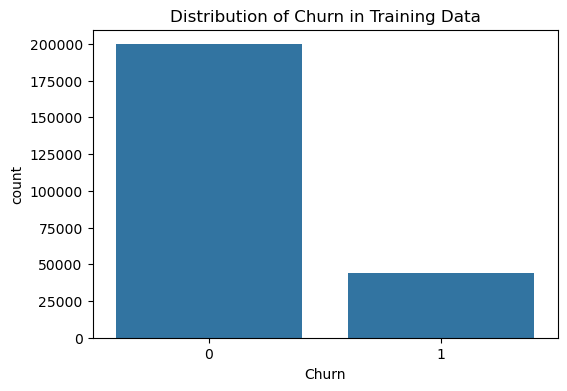

Churn value counts on training data:
 Churn
0    199605
1     44182
Name: count, dtype: int64
Churn proportions on training data:
 Churn
0    0.818768
1    0.181232
Name: proportion, dtype: float64


In [11]:
# Target variable distribution in training data
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title('Distribution of Churn in Training Data')
plt.show()
print('Churn value counts on training data:\n', y.value_counts())
print('Churn proportions on training data:\n', y.value_counts(normalize=True))

This indicates that approximately 18.1% of the subscriptions in the training data were churned, while 81.9% were retained. This class imbalance should be taken into consideration when building and evaluating predictive models, as it may affect model performance and the choice of evaluation metrics.

In [12]:
# Slipt data into training and validation subsets for model evaluation in imbalance classification problems
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  random_state=100, 
                                                  stratify=y)
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)

X_train shape: (195029, 20)
X_val shape: (48758, 20)


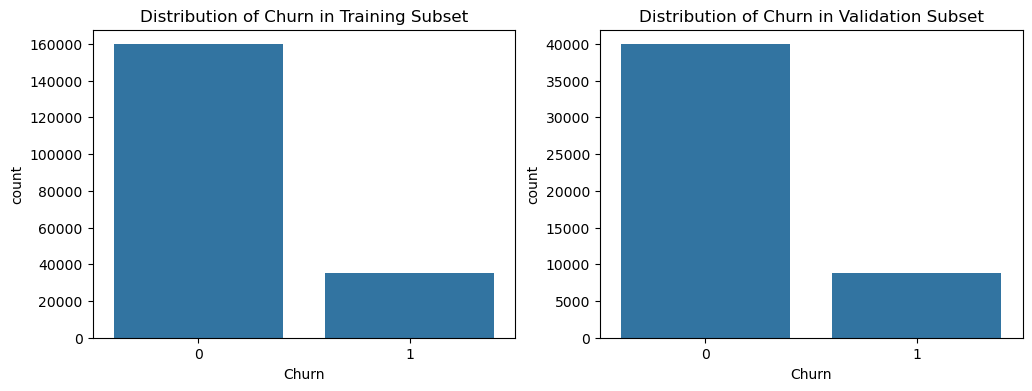

Churn proportions in training subset:
 Churn
0    0.818771
1    0.181229
Name: proportion, dtype: float64
Churn proportions in validation subset:
 Churn
0    0.818758
1    0.181242
Name: proportion, dtype: float64


In [13]:
# Target variable distribution in training and validation subsets
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Distribution of Churn in Training Subset')
plt.subplot(1, 2, 2)
sns.countplot(x=y_val)
plt.title('Distribution of Churn in Validation Subset')
plt.show()
print('Churn proportions in training subset:\n', y_train.value_counts(normalize=True))
print('Churn proportions in validation subset:\n', y_val.value_counts(normalize=True))

In [14]:
# Category columns
category_cols = X_train.select_dtypes(include=['object']).columns.tolist()
# Numerical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Display the columns
print("Categorical columns:", category_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: ['SubscriptionType', 'PaymentMethod', 'PaperlessBilling', 'ContentType', 'MultiDeviceAccess', 'DeviceRegistered', 'GenrePreference', 'Gender', 'ParentalControl', 'SubtitlesEnabled', 'CustomerID']
Numerical columns: ['AccountAge', 'MonthlyCharges', 'TotalCharges', 'ViewingHoursPerWeek', 'AverageViewingDuration', 'ContentDownloadsPerMonth', 'UserRating', 'SupportTicketsPerMonth', 'WatchlistSize']


In [15]:
# Value counts of categorial features in training data
for col in category_cols:
    print(f'\nValue counts for {col}:')
    print(X_train[col].value_counts())


Value counts for SubscriptionType:
SubscriptionType
Standard    65464
Basic       64807
Premium     64758
Name: count, dtype: int64

Value counts for PaymentMethod:
PaymentMethod
Electronic check    49119
Credit card         48807
Bank transfer       48572
Mailed check        48531
Name: count, dtype: int64

Value counts for PaperlessBilling:
PaperlessBilling
Yes    97523
No     97506
Name: count, dtype: int64

Value counts for ContentType:
ContentType
Both        65305
TV Shows    64985
Movies      64739
Name: count, dtype: int64

Value counts for MultiDeviceAccess:
MultiDeviceAccess
No     97726
Yes    97303
Name: count, dtype: int64

Value counts for DeviceRegistered:
DeviceRegistered
Computer    48937
Tablet      48902
Mobile      48772
TV          48418
Name: count, dtype: int64

Value counts for GenrePreference:
GenrePreference
Comedy     39290
Fantasy    39277
Action     39019
Drama      38859
Sci-Fi     38584
Name: count, dtype: int64

Value counts for Gender:
Gender
Male     

In [16]:
# Drop 'CustomerID' column as it is not a predictive feature
X_train = X_train.drop(columns=['CustomerID'])
X_val = X_val.drop(columns=['CustomerID'])

In [17]:
# Updated lists of columns after dropping 'CustomerID'
category_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

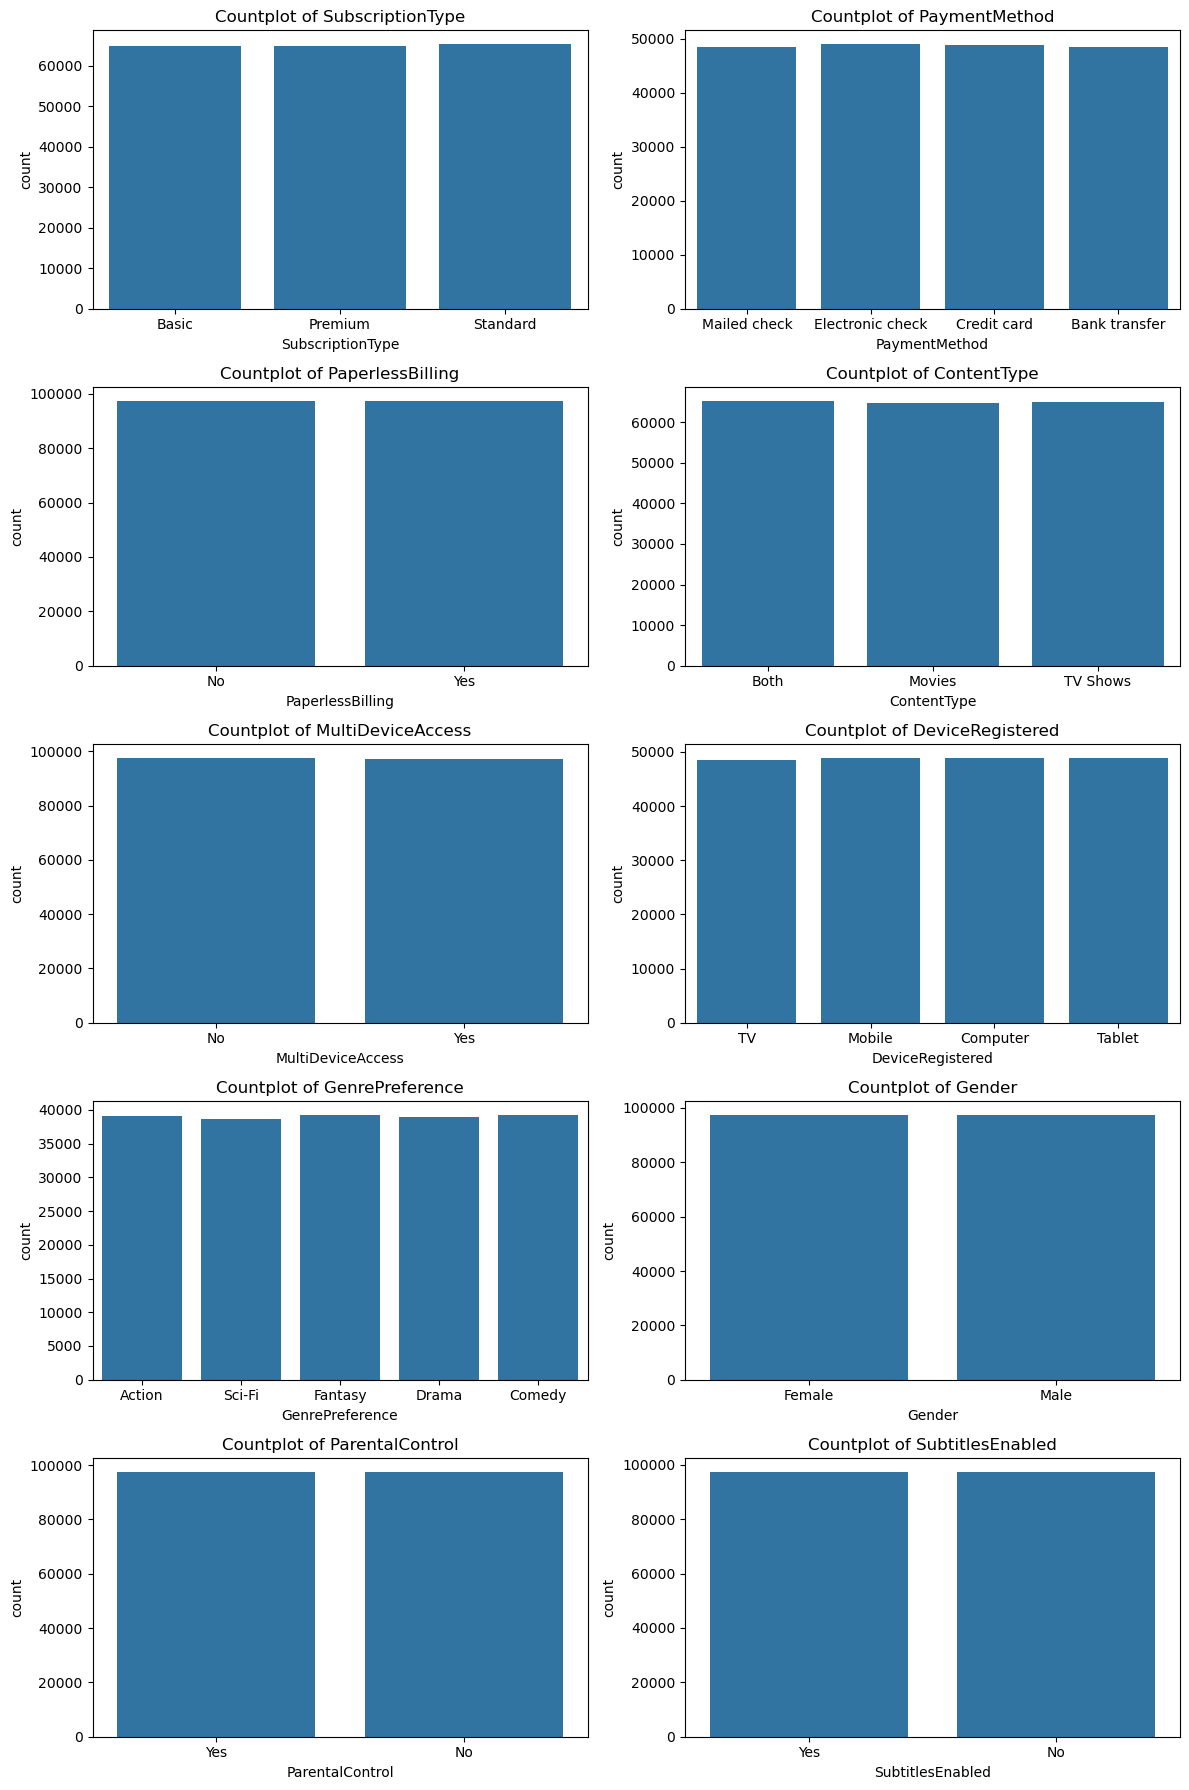

In [18]:
# Countplots of categorical columns in training data
plt.figure(figsize=(12, 18))
for i, col in enumerate(category_cols):
    plt.subplot(5, 2, i + 1)
    sns.countplot(x=X_train[col])
    plt.title(f'Countplot of {col}')
plt.tight_layout()
plt.show()

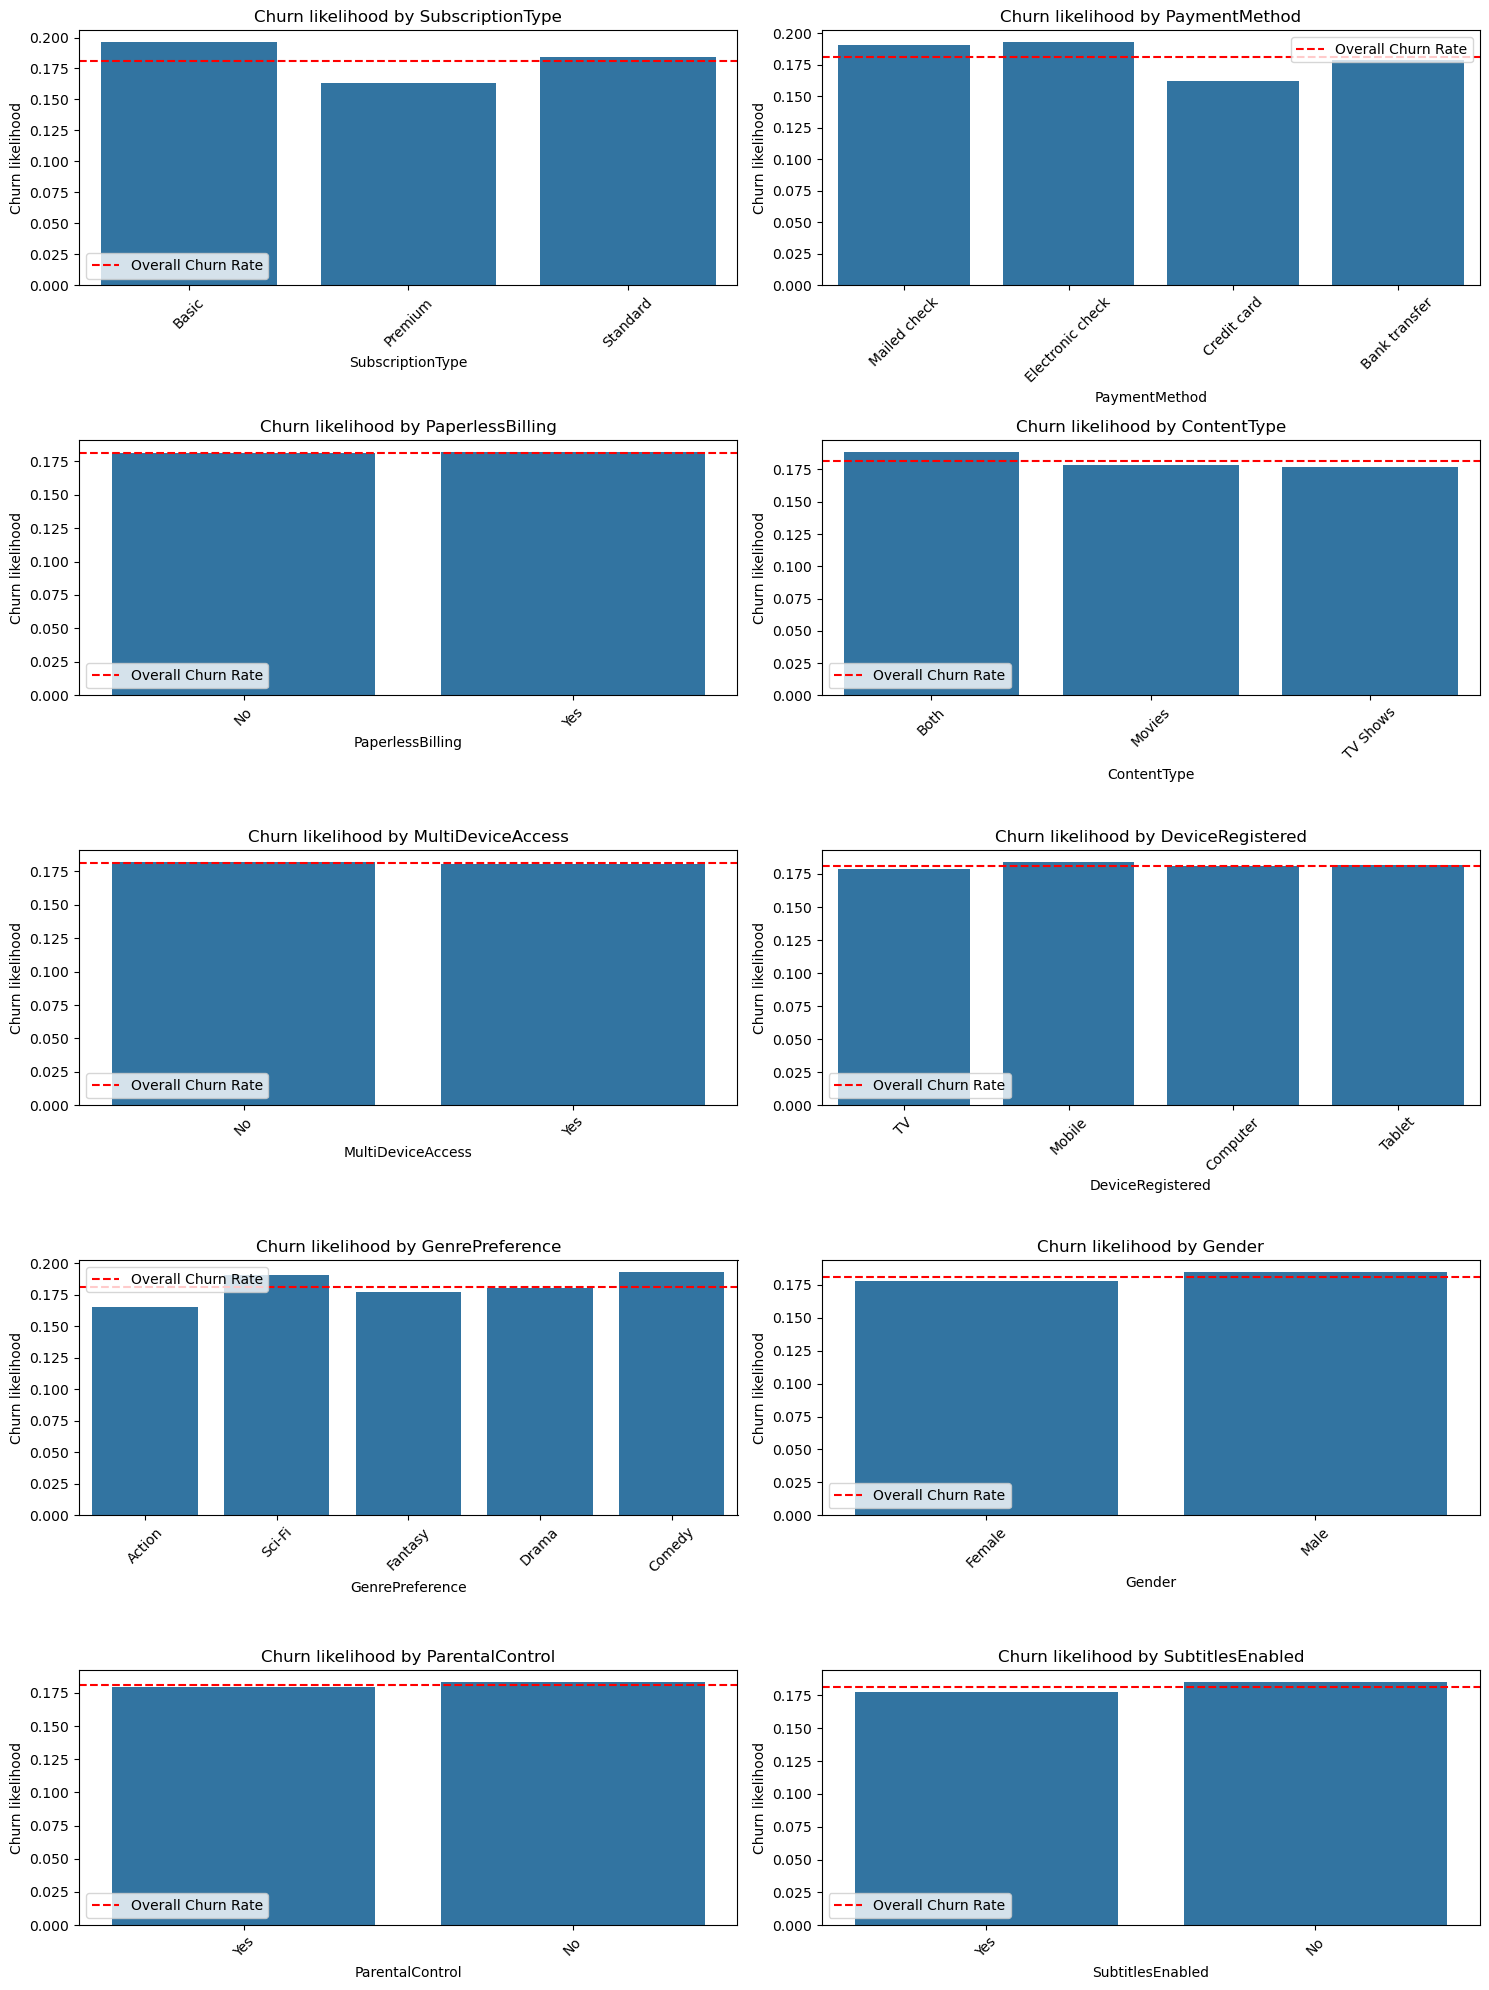

In [19]:
# The target variable likelihood for categorical features in training data subset
# Merge X_train and y_train for analysis
train_data = X_train.copy()
train_data['Churn'] = y_train.values
plt.figure(figsize=(15, 20))
for i, col in enumerate(category_cols, 1):
    plt.subplot(5, 2, i)
    sns.barplot(x=train_data[col], y=train_data['Churn'], ci=None)
    plt.title(f'Churn likelihood by {col}')
    plt.xlabel(col)
    plt.axhline(y=train_data['Churn'].mean(), color='red', linestyle='--', label='Overall Churn Rate')
    plt.ylabel('Churn likelihood')
    plt.legend()
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
# Check for negative values in numerical columns in training data
for col in numerical_cols:
    if (X_train[col] < 0).any():
        print(f'Negative values found in column: {col}')
    else:
        print(f'No negative values in column: {col}')

No negative values in column: AccountAge
No negative values in column: MonthlyCharges
No negative values in column: TotalCharges
No negative values in column: ViewingHoursPerWeek
No negative values in column: AverageViewingDuration
No negative values in column: ContentDownloadsPerMonth
No negative values in column: UserRating
No negative values in column: SupportTicketsPerMonth
No negative values in column: WatchlistSize


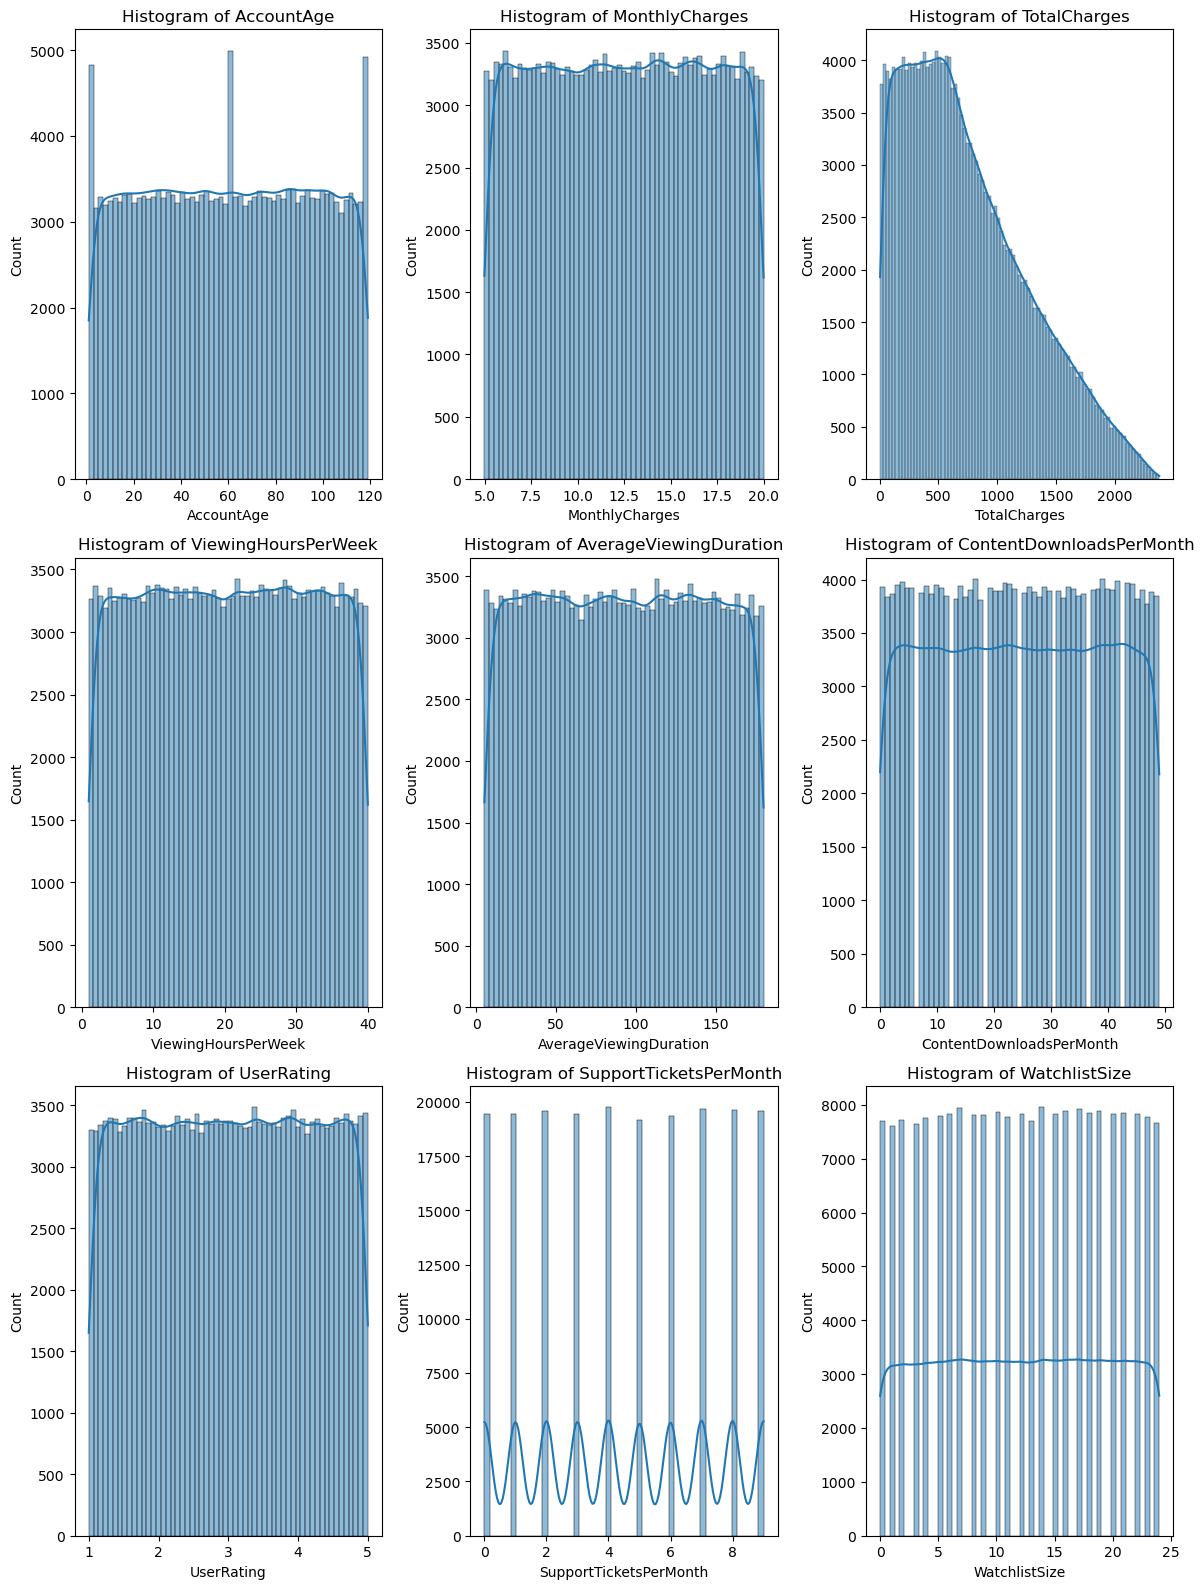

In [21]:
# Histograms of numerical columns in training data subset
plt.figure(figsize=(12, 16))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)
    sns.histplot(train_data[col], kde=True)
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

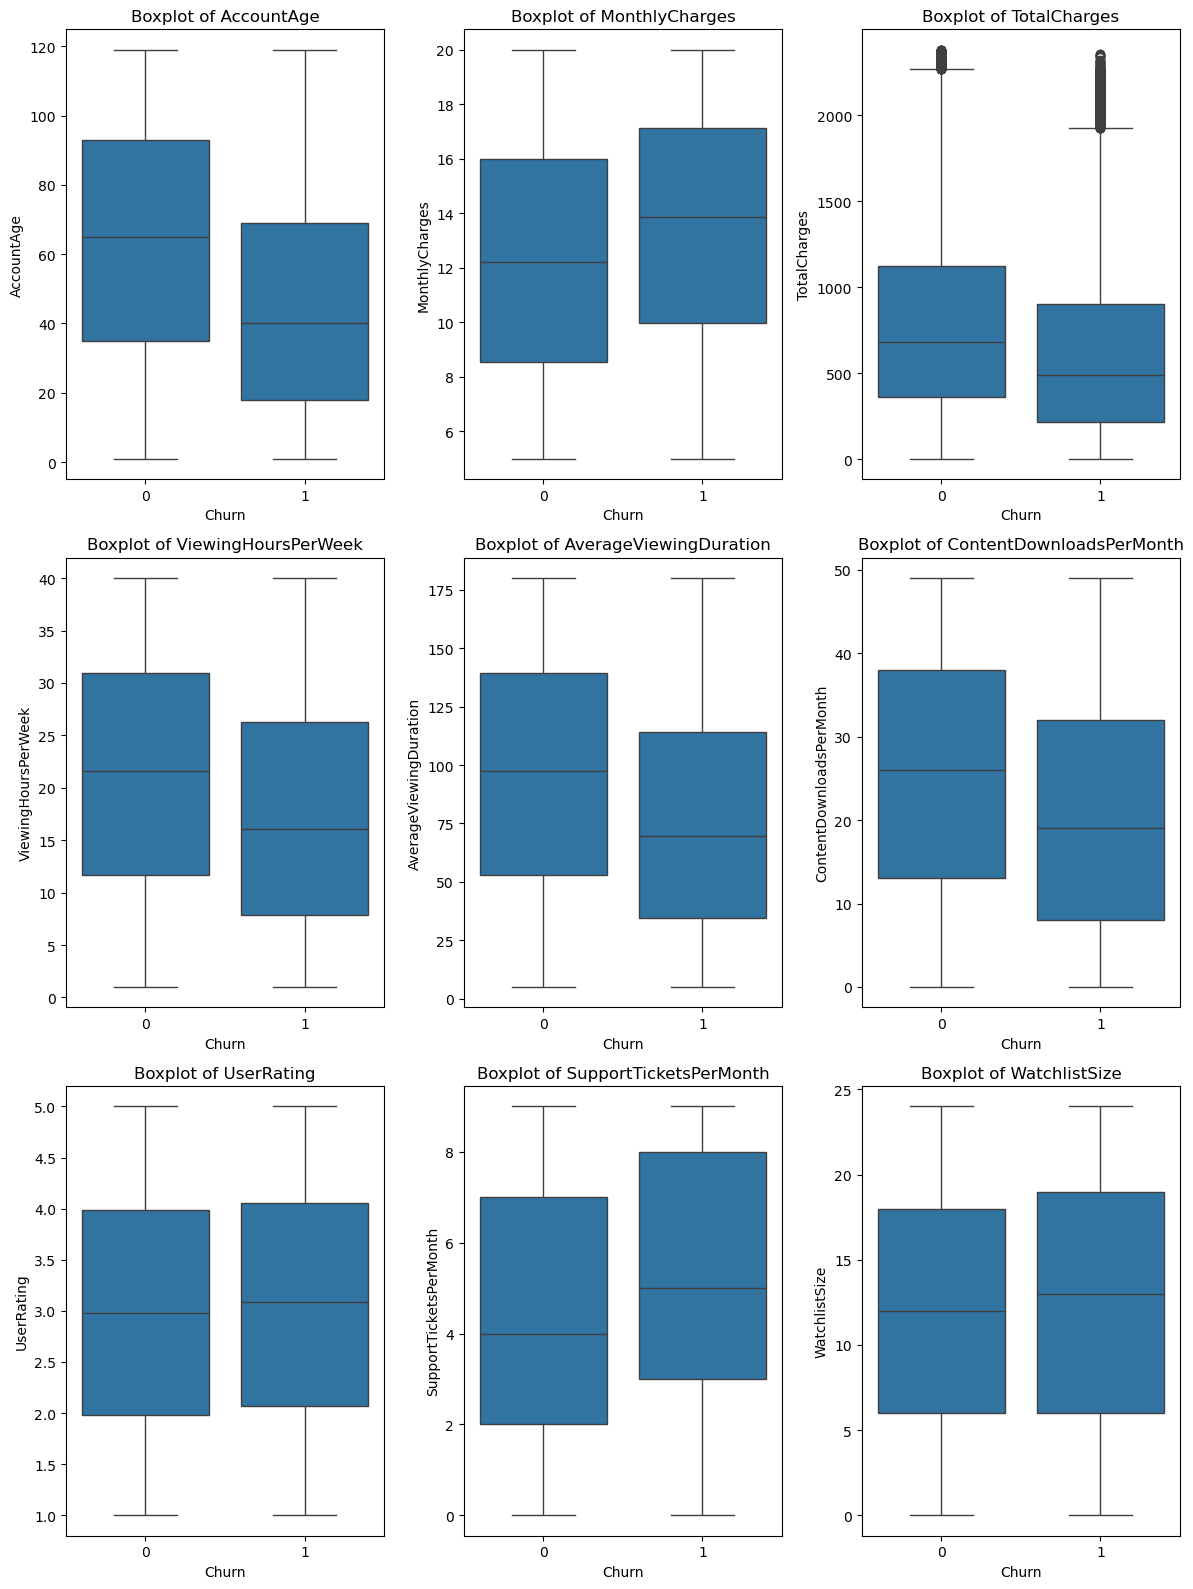

In [22]:
# Visalize outliers in numerical columns using boxplots in training data subset
plt.figure(figsize=(12, 16))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=train_data[col], x=train_data['Churn'])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

According to the boxplots above, there is evidence of outliers in column 'TotalCharges' in churn = 0 class and churn = 1 class. Other numerical columns do not show significant outliers.
- 'AccountAge': Newer accounts tend to have a slightly higher churn rate.
- 'MonthlyCharges': Higher monthly charges are associated with a higher churn rate.
- 'TotalCharges': Lower total charges are associated with a higher churn rate.
- 'ViewingHoursPerWeek', 'AverageViewingDuration', 'ContentDownloadsPerMonth': Lower values in these engagement metrics are associated with a higher churn rate.
- 'UserRating': Small differences in user ratings do not show a clear pattern with churn.
- 'SupportTicketsPerMonth': More support tickets are associated with a higher churn rate. Not satisfying customer support experiences may lead to churn.
- 'WatchlistSize': Higher watchlist sizes are associated with a higher churn rate.

In [23]:
# Clip outliers in numerical columns using 1st and 99th percentiles in training data subset
for col in numerical_cols:
    lower_bound = train_data[col].quantile(0.01)
    upper_bound = train_data[col].quantile(0.99)
    X_train[col] = np.clip(X_train[col], lower_bound, upper_bound)
    X_val[col] = np.clip(X_val[col], lower_bound, upper_bound)

# Impute TotalCharges column with median value in training and validation subsets
X_train['TotalCharges'].fillna(X_train['AccountAge'] * X_train['MonthlyCharges'], inplace=True)
X_val['TotalCharges'].fillna(X_val['AccountAge'] * X_val['MonthlyCharges'], inplace=True)

In [24]:
# Updated lists of columns after feature engineering
category_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

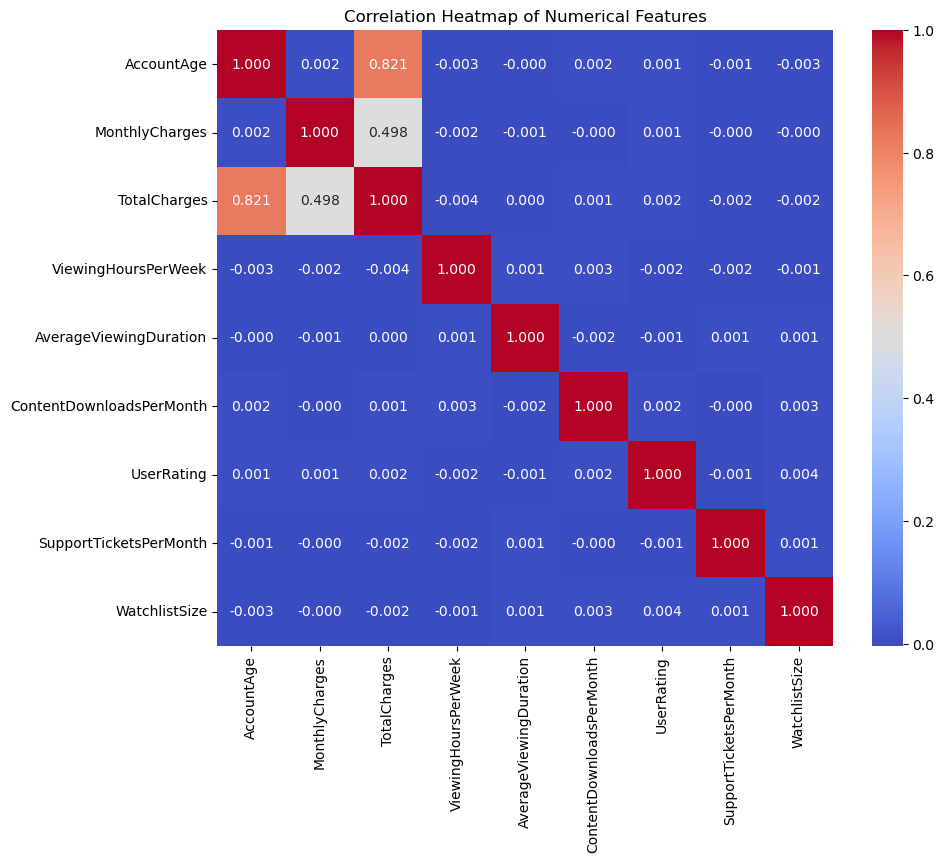

In [25]:
# Heatmap of correlations between numerical features in training data subset
numerical_cols_in_train_data = [col for col in numerical_cols if col in train_data.columns]
plt.figure(figsize=(10, 8))
sns.heatmap(train_data[numerical_cols_in_train_data].corr(), 
            annot=True, 
            fmt=".3f", 
            cmap='coolwarm', 
            square=True)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

Total charges is highly correlated with account age and monthly charges, which is expected since total charges accumulate over time based on the monthly fee. Other numerical features do not show strong correlations with each other.

In [26]:
# Updated lists of columns after feature engineering
category_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

## Train Models

### 1. Logistic Regression

In [27]:
# Encoding categorical features using one-hot encoding
X_train_reg = pd.get_dummies(X_train, columns=category_cols, drop_first=True).astype(int)
X_val_reg = pd.get_dummies(X_val, columns=category_cols, drop_first=True).astype(int)
test_df_reg = pd.get_dummies(test_df.drop(columns=['CustomerID']), columns=category_cols, drop_first=True).astype(int)

# Align the columns of the validation set with the training set
X_val_reg = X_val_reg.reindex(columns=X_train_reg.columns, fill_value=0)
# Align the columns of the test set with the training set
test_df_reg = test_df_reg.reindex(columns=X_train_reg.columns, fill_value=0)

In [28]:
# Standardize numerical features for models for Logistic Regression model
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_reg[numerical_cols] = scaler.fit_transform(X_train_reg[numerical_cols])
X_val_reg[numerical_cols] = scaler.transform(X_val_reg[numerical_cols])
test_df_reg[numerical_cols] = scaler.transform(test_df_reg[numerical_cols])


In [29]:
# Correlation analysis for multicollinearity
corr_matrix = X_train_reg.corr().abs()
high_corr_var = np.where(corr_matrix > 0.8)
high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]
print("Highly correlated variable pairs (correlation > 0.8):")
for var1, var2 in high_corr_var:
    print(f"{var1} - {var2}")

Highly correlated variable pairs (correlation > 0.8):
AccountAge - TotalCharges


In [30]:
# Drop highly correlated variables
X_train_reg = X_train_reg.drop(columns=['AccountAge'])
X_val_reg = X_val_reg.drop(columns=['AccountAge'])
test_df_reg = test_df_reg.drop(columns=['AccountAge'])

In [31]:
# Filter features with high variance inflation factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor 
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_reg.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_reg.values, i) for i in range(X_train_reg.shape[1])]
print(vif_data.sort_values(by="VIF", ascending=False))

                           feature       VIF
13            PaperlessBilling_Yes  1.901769
24                     Gender_Male  1.901711
25             ParentalControl_Yes  1.901477
26            SubtitlesEnabled_Yes  1.900641
16           MultiDeviceAccess_Yes  1.896690
9        SubscriptionType_Standard  1.859291
8         SubscriptionType_Premium  1.850295
15            ContentType_TV Shows  1.847372
14              ContentType_Movies  1.844270
11  PaymentMethod_Electronic check  1.806780
12      PaymentMethod_Mailed check  1.802184
10       PaymentMethod_Credit card  1.800226
19         DeviceRegistered_Tablet  1.799503
17         DeviceRegistered_Mobile  1.798670
18             DeviceRegistered_TV  1.790503
20          GenrePreference_Comedy  1.757275
22         GenrePreference_Fantasy  1.754757
21           GenrePreference_Drama  1.744942
23          GenrePreference_Sci-Fi  1.739984
1                     TotalCharges  1.327012
0                   MonthlyCharges  1.326973
4         

In [32]:
# Logistic Regression model using statsmodels 
import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train_reg)
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.413715
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:               195029
Model:                          Logit   Df Residuals:                   195001
Method:                           MLE   Df Model:                           27
Date:                Thu, 18 Sep 2025   Pseudo R-squ.:                  0.1258
Time:                        12:00:53   Log-Likelihood:                -80686.
converged:                       True   LL-Null:                       -92298.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.7185      0.028    -60.580     

In [33]:
# Select significant features based on p-values
significant_features = result.pvalues[result.pvalues < 0.05].index.tolist()
significant_features.remove('const')

In [34]:
# Logistic Regression model using only significant features
X_train_sm = sm.add_constant(X_train_reg[significant_features])
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.413733
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:               195029
Model:                          Logit   Df Residuals:                   195006
Method:                           MLE   Df Model:                           22
Date:                Thu, 18 Sep 2025   Pseudo R-squ.:                  0.1258
Time:                        12:00:54   Log-Likelihood:                -80690.
converged:                       True   LL-Null:                       -92298.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.7180      0.025    -69.643     

Logit Regression Results show that the following features are statistically significant (p-value < 0.05)

In [35]:
# Update datasets to keep only significant features
X_train_reg = X_train_reg[significant_features]
X_val_reg = X_val_reg[significant_features]
# Note: test_df_reg will be updated later after model evaluation

In [36]:
# Aplly for imbalance classification problems
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=100)
X_train_res, y_train_res = smote.fit_resample(X_train_reg, y_train)
print('Resampled X_train shape:', X_train_res.shape)
print('Resampled y_train distribution:\n', y_train_res.value_counts())

Resampled X_train shape: (319368, 22)
Resampled y_train distribution:
 Churn
1    159684
0    159684
Name: count, dtype: int64


In [37]:
# Train logistic regression model
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(penalty='l2', solver='saga', max_iter=5000, n_jobs=-1, random_state=100)
log_reg.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=5000, n_jobs=-1, random_state=100, solver='saga')

In [38]:
# Cross-validate model on training data using 5-fold cross-validation imbalanced classification after resampling
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
cv_scores = cross_val_score(log_reg, X_train_res, y_train_res, cv=cv, scoring='f1_macro') # Use 'f1_macro' for imbalanced classification
print('Cross-validated F1 scores:', cv_scores)
print('Mean F1 score:', cv_scores.mean())
print('Standard Deviation of F1 scores:', cv_scores.std())

Cross-validated F1 scores: [0.72164819 0.71759841 0.72213897 0.72017802 0.72252385]
Mean F1 score: 0.7208174896621422
Standard Deviation of F1 scores: 0.001795518741053277


In [39]:
# Evaluate model on training and validation subsets
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
y_train_pred = log_reg.predict(X_train_reg)
print('Training Classification Report:\n', classification_report(y_train, y_train_pred))
print('Training Confusion Matrix:\n', confusion_matrix(y_train, y_train_pred))

y_val_pred = log_reg.predict(X_val_reg)
print('Validation Classification Report:\n', classification_report(y_val, y_val_pred))
print('Validation Confusion Matrix:\n', confusion_matrix(y_val, y_val_pred))

Training Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.72      0.79    159684
           1       0.32      0.59      0.41     35345

    accuracy                           0.70    195029
   macro avg       0.60      0.65      0.60    195029
weighted avg       0.78      0.70      0.72    195029

Training Confusion Matrix:
 [[114883  44801]
 [ 14651  20694]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.72      0.80     39921
           1       0.32      0.59      0.41      8837

    accuracy                           0.70     48758
   macro avg       0.60      0.66      0.60     48758
weighted avg       0.79      0.70      0.73     48758

Validation Confusion Matrix:
 [[28721 11200]
 [ 3607  5230]]


The Precision for the churned class (1) is relatively low at 0.32 on training and 0.32 on validation, indicating a high false positive rate. This means many non-churned subscriptions are incorrectly predicted as churned. The Recall for the churned class is moderate at 0.58 on training and 0.59 on validation, meaning the model identifies about 59% of actual churned subscriptions. The f1-score for the churned class is low at 0.41 on both training and validation, reflecting the imbalance between precision and recall. All metrics are similar between training and validation, but not well on training and validation, indicating the model is not very effective at predicting churn.

In [40]:
# Tune hyperparameters using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(log_reg, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=2)
grid_search.fit(X_train_res, y_train_res)

print('Best Hyperparameters:', grid_search.best_params_)
print('Best Cross-validated F1 Score:', grid_search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best Cross-validated F1 Score: 0.7208174896621422


In [41]:
# Train logistic regression model with best hyperparameters
best_log_reg = grid_search.best_estimator_
best_log_reg.fit(X_train_res, y_train_res)

LogisticRegression(C=1, max_iter=5000, n_jobs=-1, random_state=100,
                   solver='saga')

In [42]:
# Evaluate model on training and validation subsets with best hyperparameters
y_train_pred = best_log_reg.predict(X_train_reg)
print('Training Classification Report:\n', classification_report(y_train, y_train_pred))
print('Training Confusion Matrix:\n', confusion_matrix(y_train, y_train_pred))
y_val_pred = best_log_reg.predict(X_val_reg)
print('Validation Classification Report:\n', classification_report(y_val, y_val_pred))
print('Validation Confusion Matrix:\n', confusion_matrix(y_val, y_val_pred))

Training Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.72      0.79    159684
           1       0.32      0.59      0.41     35345

    accuracy                           0.70    195029
   macro avg       0.60      0.65      0.60    195029
weighted avg       0.78      0.70      0.72    195029

Training Confusion Matrix:
 [[114883  44801]
 [ 14651  20694]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.72      0.80     39921
           1       0.32      0.59      0.41      8837

    accuracy                           0.70     48758
   macro avg       0.60      0.66      0.60     48758
weighted avg       0.79      0.70      0.73     48758

Validation Confusion Matrix:
 [[28721 11200]
 [ 3607  5230]]


Tuning hyperparameters has the same effect on model performance as before. The Precision for the churned class (1) remains relatively low at 0.32 on training and 0.32 on validation, indicating a high false positive rate. The Recall for the churned class is still 0.59 on training and 0.59 on validation. The f1-score for the churned class remains low at 0.41 on both training and validation. Overall, hyperparameter tuning did not significantly improve the model's ability to predict churn, as the metrics remain similar to before tuning.

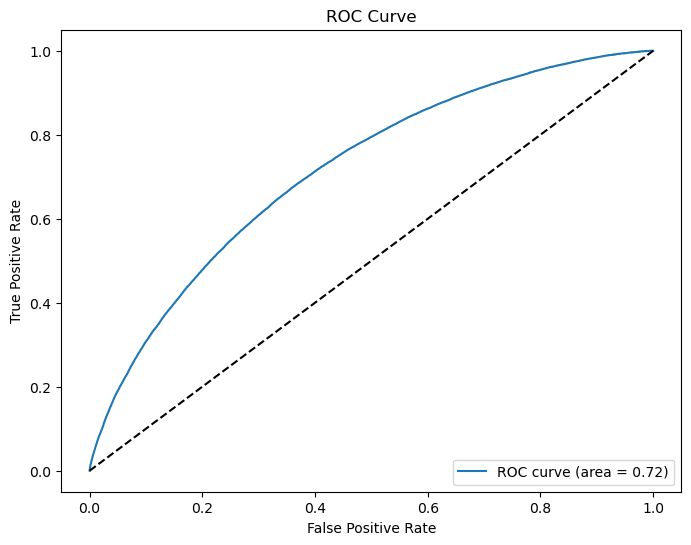

In [43]:
# Plot ROC curve for training subset
from sklearn.metrics import roc_curve, auc
y_train_probs = best_log_reg.predict_proba(X_train_reg)[:, 1]
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

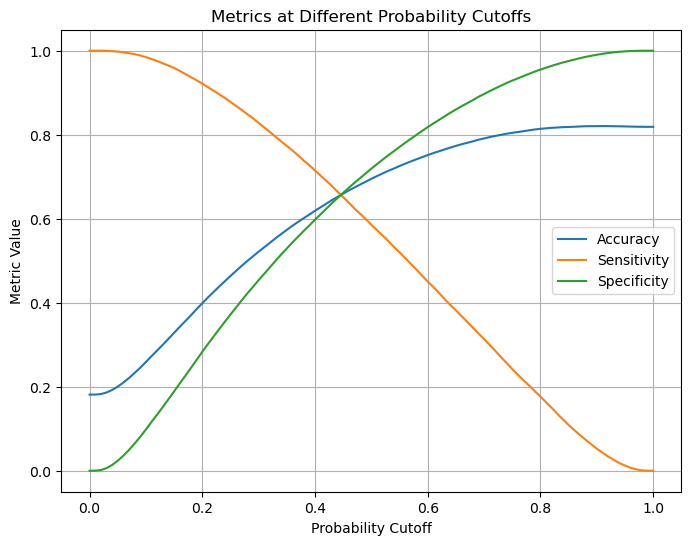

In [44]:
# Plot accuracy, sensitivity, specificity at different values of probability cutoffs
cutoffs = np.arange(0.0, 1.01, 0.01)
accuracy = []
sensitivity = []
specificity = []
for cutoff in cutoffs:
    y_train_pred_cutoff = (y_train_probs >= cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred_cutoff).ravel()
    accuracy.append((tp + tn) / (tp + tn + fp + fn))
    sensitivity.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
plt.figure(figsize=(8, 6))
plt.plot(cutoffs, accuracy, label='Accuracy')
plt.plot(cutoffs, sensitivity, label='Sensitivity')
plt.plot(cutoffs, specificity, label='Specificity')
plt.xlabel('Probability Cutoff')
plt.ylabel('Metric Value')
plt.title('Metrics at Different Probability Cutoffs')
plt.legend()
plt.grid()
plt.show()

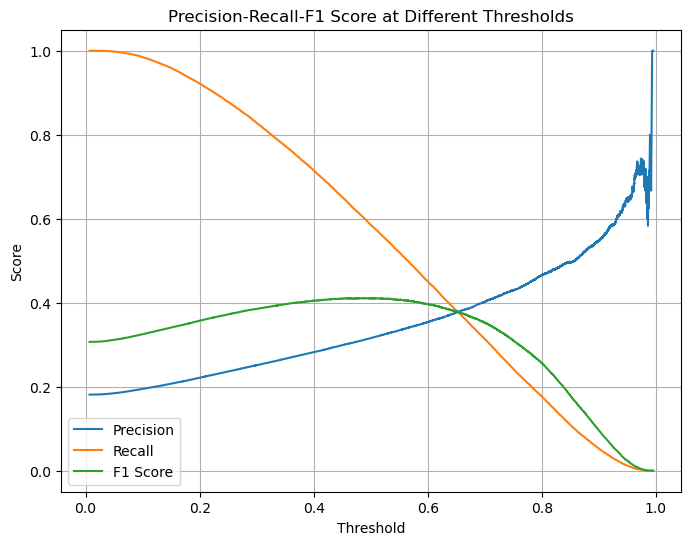

In [45]:
# Plot precision-recall curve
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_train, y_train_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-F1 Score at Different Thresholds')
plt.legend()
plt.grid()
plt.show()

- With AUC = 0.72, the logistic regression model shows moderate ability to distinguish between churned and non-churned subscriptions, better than random guessing but not highly accurate.
- The cutoff thresholds (0.1-0.2) sensitivity (recall) is very high (0.8-0.9), meaning most churned subscriptions are correctly identified, but specificity is low about 0.2, so many non-churned are incorrectly flagged as churned.
- The cutoff thresholds (0.3-0.5) sensitivity (recall) is moderate (0.8-0.6), meaning about half of churned subscriptions are identified, and specificity is also moderate (0.3-0.35), so some non-churned are incorrectly flagged.
- The cutoff thresholds (0.6-0.9) sensitivity (recall) is low (0.5-0.1), meaning many churned subscriptions are missed, but specificity is high (0.4-0.9) so most non-churned are correctly identified.
- The balanced cutoff  = 0.45 seem to reasonable for a trade-off.

In [46]:
# Evaluate model based on chosen cutoff threshold on training and validation subsets
chosen_cutoff = 0.44
y_train_pred_cutoff = (best_log_reg.predict_proba(X_train_reg)[:, 1] >= chosen_cutoff).astype(int)
print(f'Training Classification Report at cutoff {chosen_cutoff}:\n', classification_report(y_train, y_train_pred_cutoff))
print(f'Training Confusion Matrix at cutoff {chosen_cutoff}:\n', confusion_matrix(y_train, y_train_pred_cutoff))
y_val_pred_cutoff = (best_log_reg.predict_proba(X_val_reg)[:, 1] >= chosen_cutoff).astype(int)
print(f'Validation Classification Report at cutoff {chosen_cutoff}:\n', classification_report(y_val, y_val_pred_cutoff))
print(f'Validation Confusion Matrix at cutoff {chosen_cutoff}:\n', confusion_matrix(y_val, y_val_pred_cutoff))

Training Classification Report at cutoff 0.44:
               precision    recall  f1-score   support

           0       0.90      0.65      0.75    159684
           1       0.30      0.66      0.41     35345

    accuracy                           0.65    195029
   macro avg       0.60      0.66      0.58    195029
weighted avg       0.79      0.65      0.69    195029

Training Confusion Matrix at cutoff 0.44:
 [[103703  55981]
 [ 11871  23474]]
Validation Classification Report at cutoff 0.44:
               precision    recall  f1-score   support

           0       0.90      0.65      0.76     39921
           1       0.30      0.67      0.41      8837

    accuracy                           0.65     48758
   macro avg       0.60      0.66      0.58     48758
weighted avg       0.79      0.65      0.69     48758

Validation Confusion Matrix at cutoff 0.44:
 [[25998 13923]
 [ 2939  5898]]


Based on business goals and cost for false positives vs false negatives, we can shift the cutoff threshold to optimize for precision or recall as needed. For example, if false positives are very costly, we can increase the cutoff to improve precision at the expense of recall. Conversely, if missing churned subscriptions is more costly, we can lower the cutoff to improve recall.

In [47]:
# Feature importance in Logistic Regression model
feature_importance = pd.DataFrame({'Feature': X_train_reg.columns, 'Coefficient': best_log_reg.coef_[0]})
feature_importance['AbsoluteCoefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='AbsoluteCoefficient', ascending=False)
print(feature_importance)

                           Feature  Coefficient  AbsoluteCoefficient
10       PaymentMethod_Credit card    -0.815472             0.815472
17         GenrePreference_Fantasy    -0.775968             0.775968
8         SubscriptionType_Premium    -0.752514             0.752514
16           GenrePreference_Drama    -0.733704             0.733704
1                     TotalCharges    -0.705378             0.705378
18          GenrePreference_Sci-Fi    -0.662917             0.662917
15          GenrePreference_Comedy    -0.634454             0.634454
0                   MonthlyCharges     0.627247             0.627247
14            ContentType_TV Shows    -0.569887             0.569887
12      PaymentMethod_Mailed check    -0.566046             0.566046
13              ContentType_Movies    -0.564594             0.564594
9        SubscriptionType_Standard    -0.551261             0.551261
11  PaymentMethod_Electronic check    -0.532797             0.532797
3           AverageViewingDuration

### 2. Random Forest

In [48]:
# Feature engineering based on 'AccountAge' and 'MonthlyCharges' high correlation
X_train['AvgMonthlyCharge'] = X_train['MonthlyCharges'] / X_train['AccountAge']
X_val['AvgMonthlyCharge'] = X_val['MonthlyCharges'] / X_val['AccountAge']
test_df['AvgMonthlyCharge'] = test_df['MonthlyCharges'] / test_df['AccountAge']
# Ratio price per content download
X_train['PricePerContentDownload'] = X_train['MonthlyCharges'] / (X_train['ContentDownloadsPerMonth'] + 1e-16)
X_val['PricePerContentDownload'] = X_val['MonthlyCharges'] / (X_val['ContentDownloadsPerMonth'] + 1e-16)
test_df['PricePerContentDownload'] = test_df['MonthlyCharges'] / (test_df['ContentDownloadsPerMonth'] + 1e-16)
# Ratio price per viewing hour
X_train['PricePerViewingHour'] = X_train['MonthlyCharges'] / (X_train['ViewingHoursPerWeek'] * 4 + 1e-16)
X_val['PricePerViewingHour'] = X_val['MonthlyCharges'] / (X_val['ViewingHoursPerWeek'] * 4 + 1e-16)
test_df['PricePerViewingHour'] = test_df['MonthlyCharges'] / (test_df['ViewingHoursPerWeek'] * 4 + 1e-16)
# Ticket per month per viewing
X_train['TicketsPerViewingHour'] = X_train['SupportTicketsPerMonth'] / (X_train['ViewingHoursPerWeek'] * 4 + 1e-16)
X_val['TicketsPerViewingHour'] = X_val['SupportTicketsPerMonth'] / (X_val['ViewingHoursPerWeek'] * 4 + 1e-16)
test_df['TicketsPerViewingHour'] = test_df['SupportTicketsPerMonth'] / (test_df['ViewingHoursPerWeek'] * 4 + 1e-16)
# Engagement score
X_train['EngagementScore'] = (X_train['ViewingHoursPerWeek'] * 4) + (X_train['ContentDownloadsPerMonth']) + (X_train['AverageViewingDuration'])
X_val['EngagementScore'] = (X_val['ViewingHoursPerWeek'] * 4) + (X_val['ContentDownloadsPerMonth']) + (X_val['AverageViewingDuration'])
test_df['EngagementScore'] = (test_df['ViewingHoursPerWeek'] * 4) + (test_df['ContentDownloadsPerMonth']) + (test_df['AverageViewingDuration'])
# Charge Efficiency
X_train['ChargeEfficiency'] = X_train['TotalCharges'] / (X_train['ViewingHoursPerWeek'] * 4 + 1e-16)
X_val['ChargeEfficiency'] = X_val['TotalCharges'] / (X_val['ViewingHoursPerWeek'] * 4 + 1e-16)
test_df['ChargeEfficiency'] = test_df['TotalCharges'] / (test_df['ViewingHoursPerWeek'] * 4 + 1e-16)
# Ticket Bin
X_train['TicketBin'] = pd.cut(X_train['SupportTicketsPerMonth'], bins=[0, 2, 5, np.inf], labels=['Low', 'Medium', 'High']).astype('category')
X_val['TicketBin'] = pd.cut(X_val['SupportTicketsPerMonth'], bins=[0, 2, 5, np.inf], labels=['Low', 'Medium', 'High']).astype('category')
test_df['TicketBin'] = pd.cut(test_df['SupportTicketsPerMonth'], bins=[0, 2, 5, np.inf], labels=['Low', 'Medium', 'High']).astype('category')

# Add 'NoTicket' to categories before filling NA
X_train['TicketBin'] = X_train['TicketBin'].cat.add_categories(['NoTicket'])
X_val['TicketBin'] = X_val['TicketBin'].cat.add_categories(['NoTicket'])
test_df['TicketBin'] = test_df['TicketBin'].cat.add_categories(['NoTicket'])

X_train['TicketBin'].fillna('NoTicket', inplace=True)
X_val['TicketBin'].fillna('NoTicket', inplace=True)
test_df['TicketBin'].fillna('NoTicket', inplace=True)
# Engagement per download
X_train['EngagementPerDownload'] = X_train['AverageViewingDuration'] / (X_train['ContentDownloadsPerMonth'] + 1e-16)
X_val['EngagementPerDownload'] = X_val['AverageViewingDuration'] / (X_val['ContentDownloadsPerMonth'] + 1e-16)
test_df['EngagementPerDownload'] = test_df['AverageViewingDuration'] / (test_df['ContentDownloadsPerMonth'] + 1e-16)


In [49]:
# Updated lists of columns after feature engineering
category_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [50]:
# Check data for train and test datasets for Random Forest model
X_train_rf = X_train.copy()
y_train_rf = y_train.copy()
X_val_rf = X_val.copy()
y_val_rf = y_val.copy()
print('X_train_rf shape:', X_train_rf.shape)
print('X_val_rf shape:', X_val_rf.shape)
print('y_train_rf distribution:\n', y_train_rf.value_counts(normalize=True))
print('y_val_rf distribution:\n', y_val_rf.value_counts(normalize=True))

X_train_rf shape: (195029, 27)
X_val_rf shape: (48758, 27)
y_train_rf distribution:
 Churn
0    0.818771
1    0.181229
Name: proportion, dtype: float64
y_val_rf distribution:
 Churn
0    0.818758
1    0.181242
Name: proportion, dtype: float64


In [51]:
# Encoding categorical features using one-hot encoding for Random Forest model
X_train_rf = pd.get_dummies(X_train_rf, columns=category_cols, drop_first=False).astype(int)
X_val_rf = pd.get_dummies(X_val_rf, columns=category_cols, drop_first=False).astype(int)
test_df_rf = pd.get_dummies(test_df.drop(columns=['CustomerID']), columns=category_cols, drop_first=False).astype(int)
# Align the columns of the validation set with the training set
X_val_rf = X_val_rf.reindex(columns=X_train_rf.columns, fill_value=0)
# Align the columns of the test set with the training set
test_df_rf = test_df_rf.reindex(columns=X_train_rf.columns, fill_value=0)

In [52]:
# Define Random Forest model
rf_clf = RandomForestClassifier(random_state=100, 
                                n_jobs=-1, 
                                bootstrap=True)

# Fit the model
rf_clf.fit(X_train_rf, y_train_rf)
# Evaluate model on training and validation subsets
y_train_rf_pred = rf_clf.predict(X_train_rf)
print('Training Classification Report:\n', classification_report(y_train_rf, y_train_rf_pred))
print('Training Confusion Matrix:\n', confusion_matrix(y_train_rf, y_train_rf_pred))
y_val_rf_pred = rf_clf.predict(X_val_rf)
print('Validation Classification Report:\n', classification_report(y_val_rf, y_val_rf_pred))
print('Validation Confusion Matrix:\n', confusion_matrix(y_val_rf, y_val_rf_pred))


Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    159684
           1       1.00      1.00      1.00     35345

    accuracy                           1.00    195029
   macro avg       1.00      1.00      1.00    195029
weighted avg       1.00      1.00      1.00    195029

Training Confusion Matrix:
 [[159684      0]
 [     3  35342]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90     39921
           1       0.54      0.09      0.15      8837

    accuracy                           0.82     48758
   macro avg       0.68      0.54      0.53     48758
weighted avg       0.78      0.82      0.76     48758

Validation Confusion Matrix:
 [[39247   674]
 [ 8052   785]]


 The Random Forest model shows signs of overfitting, with near-perfect performance on the training set but significantly lower performance on the validation set. The Precision for the churned class (1) is moderate at 0.54 on validation, indicating that when the model predicts churn, it is correct 54% of the time. However, the Recall for the churned class is very low at 0.08 on validation, meaning the model only identifies 8% of actual churned subscriptions. The f1-score for the churned class is also low at 0.14 on validation, reflecting the imbalance between precision and recall. Overall, while the model performs well on training data, its ability to generalize to unseen data is limited, particularly in identifying churned subscriptions.

In [53]:
# Tune hyperparameters using HalvingRandomSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4], 
    'class_weight': ['balanced', 'balanced_subsample']
}
rf_clf = RandomForestClassifier(random_state=100,
                                n_jobs=-1,
                                bootstrap=True)
halving_search = HalvingRandomSearchCV(rf_clf, param_dist, cv=cv, factor=5, scoring='f1_macro', n_candidates='exhaust', n_jobs=-1, verbose=2, random_state=100)
halving_search.fit(X_train_rf, y_train_rf)
print('Best Hyperparameters:', halving_search.best_params_)
print('Best Cross-validated F1 Score:', halving_search.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 6
min_resources_: 20
max_resources_: 195029
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 324
n_resources: 20
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
----------
iter: 1
n_candidates: 65
n_resources: 100
Fitting 5 folds for each of 65 candidates, totalling 325 fits
----------
iter: 2
n_candidates: 13
n_resources: 500
Fitting 5 folds for each of 13 candidates, totalling 65 fits
----------
iter: 3
n_candidates: 3
n_resources: 2500
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'class_weight': 'balanced'}
Best Cross-validated F1 Score: 0.6112352283493732


In [54]:
# Evaluate Random Forest model on train and validation data subsets
rf_best_estimator = halving_search.best_estimator_
y_train_rf_pred = rf_best_estimator.predict(X_train_rf)
print('Training Classification Report:\n', classification_report(y_train_rf, y_train_rf_pred))
print('Training Confusion Matrix:\n', confusion_matrix(y_train_rf, y_train_rf_pred))
y_val_rf_pred = rf_best_estimator.predict(X_val_rf)
print('Validation Classification Report:\n', classification_report(y_val_rf, y_val_rf_pred))
print('Validation Confusion Matrix:\n', confusion_matrix(y_val_rf, y_val_rf_pred))

Training Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.71      0.80    159684
           1       0.35      0.71      0.47     35345

    accuracy                           0.71    195029
   macro avg       0.63      0.71      0.63    195029
weighted avg       0.81      0.71      0.74    195029

Training Confusion Matrix:
 [[113032  46652]
 [ 10383  24962]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.70      0.79     39921
           1       0.32      0.66      0.43      8837

    accuracy                           0.69     48758
   macro avg       0.61      0.68      0.61     48758
weighted avg       0.80      0.69      0.72     48758

Validation Confusion Matrix:
 [[27809 12112]
 [ 3017  5820]]


After tuning hyperparameters, the Random Forest model reduces overfitting, with slightly lower performance on the training set but improved performance on the validation set. The Recall for the churned class (1) from 0.08 to 0.66 on validation, meaning the model now identifies 66% of actual churned subscriptions, a significant improvement. The Precision for the churned class is moderate at 0.32 on validation, indicating that when the model predicts churn, it is correct 32% of the time. The f1-score for the churned class improves to 0.43 on validation, reflecting a better balance between precision and recall. Overall, hyperparameter tuning has enhanced the model's ability to generalize to unseen data, particularly in identifying churned subscriptions.

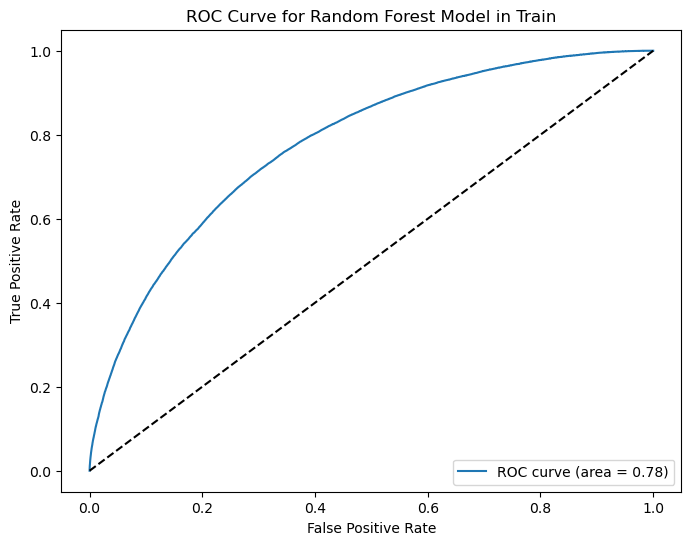

In [55]:
# Plot ROC curve for training subset for Random Forest model
y_train_rf_probs = rf_best_estimator.predict_proba(X_train_rf)[:, 1]
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_train_rf, y_train_rf_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Model in Train')
plt.legend(loc='lower right')
plt.show()

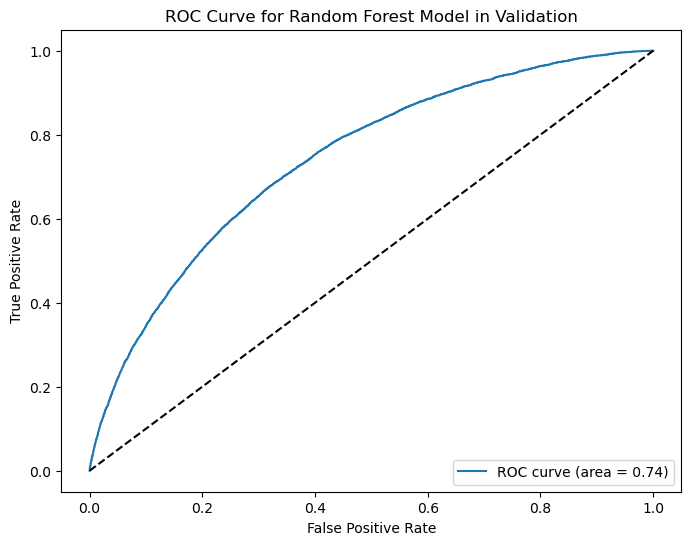

In [56]:
# Plot ROC curve for validation subset for Random Forest model
y_val_rf_probs = rf_best_estimator.predict_proba(X_val_rf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val_rf, y_val_rf_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Model in Validation')
plt.legend(loc='lower right')
plt.show()

The ROC curve for Random Forest model in train shows moderate performance with an AUC of 0.78, and AUC of 0.74 on validation, indicating good ability to distinguish between churned and non-churned subscriptions. The model performs well across various threshold settings, with high sensitivity (recall) at lower thresholds and high specificity at higher thresholds.

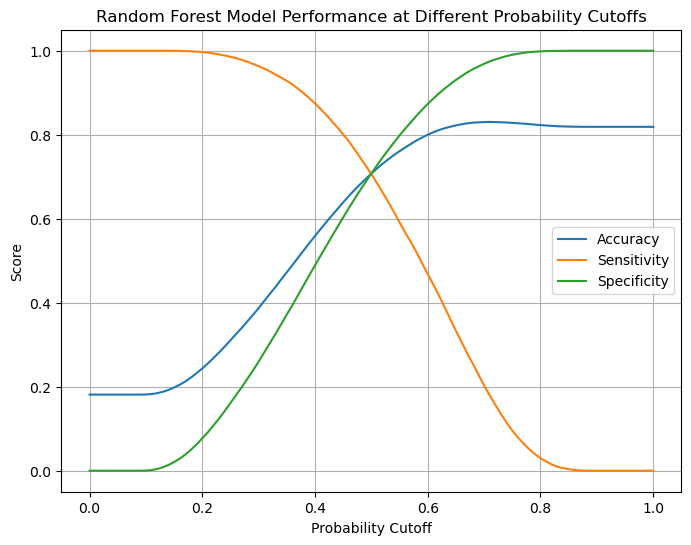

In [57]:
# Plot accuracy, sensitivity, specificity at different values of probability cutoffs for Random Forest model
cutoffs = np.arange(0.0, 1.01, 0.01)
accuracy = []
sensitivity = []
specificity = []
for cutoff in cutoffs:
    y_train_rf_pred_cutoff = (y_train_rf_probs >= cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_train_rf, y_train_rf_pred_cutoff).ravel()
    accuracy.append((tp + tn) / (tp + tn + fp + fn))
    sensitivity.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
plt.figure(figsize=(8, 6))
plt.plot(cutoffs, accuracy, label='Accuracy')
plt.plot(cutoffs, sensitivity, label='Sensitivity')
plt.plot(cutoffs, specificity, label='Specificity')
plt.xlabel('Probability Cutoff')
plt.ylabel('Score')
plt.title('Random Forest Model Performance at Different Probability Cutoffs')
plt.legend()
plt.grid()
plt.show()

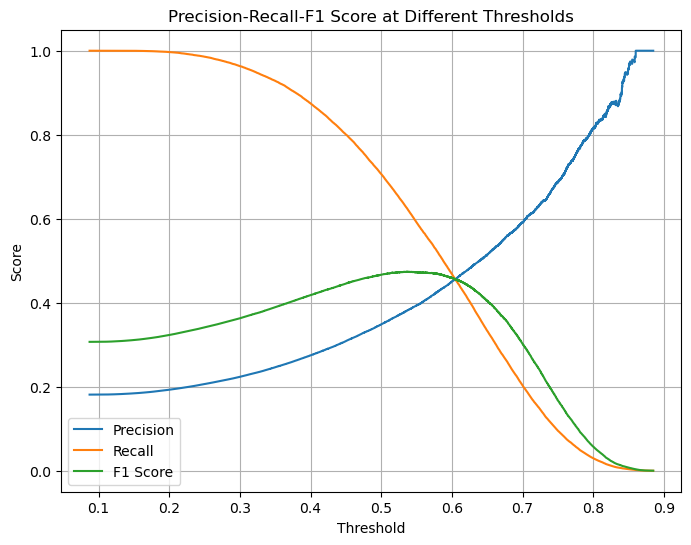

In [58]:
# Plot precision-recall curve for Random Forest model
precision, recall, thresholds = precision_recall_curve(y_train_rf, y_train_rf_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-F1 Score at Different Thresholds')
plt.legend()
plt.grid()
plt.show()

In [59]:
# Evaluate model based on chosen cutoff threshold on training and validation subsets for Random Forest model
chosen_cutoff = 0.40
y_train_rf_pred_cutoff = (y_train_rf_probs >= chosen_cutoff).astype(int)
print(f'Training Classification Report at cutoff {chosen_cutoff}:\n', classification_report(y_train_rf, y_train_rf_pred_cutoff))
print(f'Training Confusion Matrix at cutoff {chosen_cutoff}:\n', confusion_matrix(y_train_rf, y_train_rf_pred_cutoff))
y_val_rf_pred_cutoff = (y_val_rf_probs >= chosen_cutoff).astype(int)
print(f'Validation Classification Report at cutoff {chosen_cutoff}:\n', classification_report(y_val_rf, y_val_rf_pred_cutoff))
print(f'Validation Confusion Matrix at cutoff {chosen_cutoff}:\n', confusion_matrix(y_val_rf, y_val_rf_pred_cutoff))

Training Classification Report at cutoff 0.4:
               precision    recall  f1-score   support

           0       0.95      0.49      0.64    159684
           1       0.27      0.87      0.42     35345

    accuracy                           0.56    195029
   macro avg       0.61      0.68      0.53    195029
weighted avg       0.82      0.56      0.60    195029

Training Confusion Matrix at cutoff 0.4:
 [[78111 81573]
 [ 4436 30909]]
Validation Classification Report at cutoff 0.4:
               precision    recall  f1-score   support

           0       0.93      0.48      0.63     39921
           1       0.26      0.84      0.40      8837

    accuracy                           0.54     48758
   macro avg       0.60      0.66      0.52     48758
weighted avg       0.81      0.54      0.59     48758

Validation Confusion Matrix at cutoff 0.4:
 [[19144 20777]
 [ 1428  7409]]


The trade-off at cutoff 0.4 seems reasonable, with improved recall for the churned class (1) at the expense of some precision. This may be suitable if identifying most churned subscriptions is a priority. We can further adjust the cutoff based on business needs. The results are similar between training and validation, indicating the model generalizes reasonably well at this cutoff. The pattern of precision-recall trade-off in an imbalanced dataset is typical, where improving recall often comes at the cost of precision.

In [60]:
# Feature importance in Random Forest model
importances = rf_best_estimator.feature_importances_
feature_names = X_train_rf.columns
# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

                           Feature  Importance
13                 EngagementScore    0.191850
0                       AccountAge    0.178127
4           AverageViewingDuration    0.087803
2                     TotalCharges    0.078437
5         ContentDownloadsPerMonth    0.069212
3              ViewingHoursPerWeek    0.058200
1                   MonthlyCharges    0.054348
10         PricePerContentDownload    0.042475
14                ChargeEfficiency    0.035753
9                 AvgMonthlyCharge    0.034145
7           SupportTicketsPerMonth    0.027946
15           EngagementPerDownload    0.027416
47                  TicketBin_High    0.016215
8                    WatchlistSize    0.012592
11             PricePerViewingHour    0.007198
6                       UserRating    0.005782
17        SubscriptionType_Premium    0.004500
48              TicketBin_NoTicket    0.004467
45                   TicketBin_Low    0.004209
20       PaymentMethod_Credit card    0.003564
16          S

### 3. XGBoost

In [61]:
# Dataset for XGBoost model
# Training
X_train_xgb = X_train_rf.copy()
y_train_xgb = y_train_rf.copy()
print('X_train_xgb shape:', X_train_xgb.shape)
print('y_train_xgb distribution:\n', y_train_xgb.value_counts(normalize=True))
# Validation
X_val_xgb = X_val_rf.copy()
y_val_xgb = y_val_rf.copy()
print('X_val_xgb shape:', X_val_xgb.shape)
print('y_val_xgb distribution:\n', y_val_xgb.value_counts(normalize=True))
# Test
test_df_xgb = test_df_rf.copy()
print('test_df_xgb shape:', test_df_xgb.shape)

X_train_xgb shape: (195029, 49)
y_train_xgb distribution:
 Churn
0    0.818771
1    0.181229
Name: proportion, dtype: float64
X_val_xgb shape: (48758, 49)
y_val_xgb distribution:
 Churn
0    0.818758
1    0.181242
Name: proportion, dtype: float64
test_df_xgb shape: (104480, 49)


In [62]:
# Library for XGBoost model
from xgboost import XGBClassifier
# XGBoost model for imbalance classification
xgb_clf = XGBClassifier(objective='binary:logistic',
                            eval_metric='aucpr',
                            use_label_encoder=False,
                            random_state=100,
                            n_jobs=-1)
# Fit the model
xgb_clf.fit(X_train_xgb, y_train_xgb)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, ...)

In [63]:
# Evaluate model on training and validation subsets
y_train_xgb_pred = xgb_clf.predict(X_train_xgb)
print('Training Classification Report:\n', classification_report(y_train_xgb, y_train_xgb_pred))
print('Training Confusion Matrix:\n', confusion_matrix(y_train_xgb, y_train_xgb_pred))
y_val_xgb_pred = xgb_clf.predict(X_val_xgb)
print('Validation Classification Report:\n', classification_report(y_val_xgb, y_val_xgb_pred))
print('Validation Confusion Matrix:\n', confusion_matrix(y_val_xgb, y_val_xgb_pred))


Training Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91    159684
           1       0.73      0.18      0.29     35345

    accuracy                           0.84    195029
   macro avg       0.79      0.58      0.60    195029
weighted avg       0.82      0.84      0.80    195029

Training Confusion Matrix:
 [[157328   2356]
 [ 28983   6362]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90     39921
           1       0.53      0.12      0.20      8837

    accuracy                           0.82     48758
   macro avg       0.68      0.55      0.55     48758
weighted avg       0.78      0.82      0.77     48758

Validation Confusion Matrix:
 [[38962   959]
 [ 7736  1101]]


XGBoost model shows signs of overfitting, with high performance on the training set but significantly lower performance on the validation set. The Precision for the churned class (1) is moderate at 0.53 on validation, indicating that when the model predicts churn, it is correct 53% of the time. However, the Recall for the churned class is very low at 0.12 on validation, meaning the model only identifies 12% of actual churned subscriptions. The f1-score for the churned class is also low at 0.20 on validation, reflecting the imbalance between precision and recall. Overall, while the model performs well on training data, its ability to generalize to unseen data is limited, particularly in identifying churned subscriptions.

In [64]:
# Scale of churn ratio
not_churn, churn = np.bincount(y_train_xgb)
scale_pos_weight = not_churn / churn
print('Scale of positive class (churn):', scale_pos_weight)


Scale of positive class (churn): 4.517866742113453


In [65]:
'''# Tuning hyperparameters using HalvingRandomSearchCV for XGBoost model
from scipy.stats import uniform, randint

xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                            eval_metric='aucpr', 
                            scale_pos_weight=scale_pos_weight,
                            use_label_encoder=False,
                            random_state=100,
                            n_jobs=-1)
# Pipeline
xgb_pipeline = Pipeline(steps=[('xgb', xgb_clf)])
# Hyperparameter distributions
param_dist = {
    'xgb__min_child_weight': randint(5, 10),
    'xgb__max_depth': randint(8, 14),
    'xgb__learning_rate': uniform(0.03, 0.06),
    'xgb__subsample': uniform(0.6, 0.2),
    'xgb__colsample_bytree': uniform(0.7, 0.2),
    'xgb__scale_pos_weight': [scale_pos_weight]
}
# Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)
# Halving Random Search CV
halving_search = HalvingRandomSearchCV(estimator=xgb_pipeline, 
                                       param_distributions=param_dist, 
                                       cv=cv, 
                                       factor=3, 
                                       min_resources=50,
                                       max_resources=1200,
                                       scoring='f1_macro', 
                                       n_candidates=100, 
                                       resource='xgb__n_estimators',
                                       n_jobs=-1, 
                                       verbose=2, 
                                       random_state=100)
# Fit the model
halving_search.fit(X_train_xgb, y_train_xgb)
best_xgb_clf = halving_search.best_estimator_
print('Best Hyperparameters:', halving_search.best_params_)
print('Best Cross-validated F1 Score:', halving_search.best_score_)'''

"# Tuning hyperparameters using HalvingRandomSearchCV for XGBoost model\nfrom scipy.stats import uniform, randint\n\nxgb_clf = xgb.XGBClassifier(objective='binary:logistic',\n                            eval_metric='aucpr', \n                            scale_pos_weight=scale_pos_weight,\n                            use_label_encoder=False,\n                            random_state=100,\n                            n_jobs=-1)\n# Pipeline\nxgb_pipeline = Pipeline(steps=[('xgb', xgb_clf)])\n# Hyperparameter distributions\nparam_dist = {\n    'xgb__min_child_weight': randint(5, 10),\n    'xgb__max_depth': randint(8, 14),\n    'xgb__learning_rate': uniform(0.03, 0.06),\n    'xgb__subsample': uniform(0.6, 0.2),\n    'xgb__colsample_bytree': uniform(0.7, 0.2),\n    'xgb__scale_pos_weight': [scale_pos_weight]\n}\n# Stratified K-Fold cross-validation\ncv = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)\n# Halving Random Search CV\nhalving_search = HalvingRandomSearchCV(estimator=x

In [66]:
'''n_iterations: 3
n_required_iterations: 5
n_possible_iterations: 3
min_resources_: 50
max_resources_: 1200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 100
n_resources: 50
Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------
iter: 1
n_candidates: 34
n_resources: 150
Fitting 3 folds for each of 34 candidates, totalling 102 fits
----------
iter: 2
n_candidates: 12
n_resources: 450
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Hyperparameters: {'xgb__colsample_bytree': 0.8460306848551853, 'xgb__learning_rate': 0.03196074568910224, 'xgb__max_depth': 13, 'xgb__min_child_weight': 9, 'xgb__scale_pos_weight': 4.517866742113453, 'xgb__subsample': 0.795300025403171, 'xgb__n_estimators': 450}
Best Cross-validated F1 Score: 0.6323309792576697'''

"n_iterations: 3\nn_required_iterations: 5\nn_possible_iterations: 3\nmin_resources_: 50\nmax_resources_: 1200\naggressive_elimination: False\nfactor: 3\n----------\niter: 0\nn_candidates: 100\nn_resources: 50\nFitting 3 folds for each of 100 candidates, totalling 300 fits\n----------\niter: 1\nn_candidates: 34\nn_resources: 150\nFitting 3 folds for each of 34 candidates, totalling 102 fits\n----------\niter: 2\nn_candidates: 12\nn_resources: 450\nFitting 3 folds for each of 12 candidates, totalling 36 fits\nBest Hyperparameters: {'xgb__colsample_bytree': 0.8460306848551853, 'xgb__learning_rate': 0.03196074568910224, 'xgb__max_depth': 13, 'xgb__min_child_weight': 9, 'xgb__scale_pos_weight': 4.517866742113453, 'xgb__subsample': 0.795300025403171, 'xgb__n_estimators': 450}\nBest Cross-validated F1 Score: 0.6323309792576697"

After tuning hyperparameters for several times, the highest F1-score of training subset is 0.6323. At parameters: {'xgb__colsample_bytree': 0.8460306848551853, 'xgb__learning_rate': 0.03196074568910224, 'xgb__max_depth': 13, 'xgb__min_child_weight': 9, 'xgb__scale_pos_weight': 4.517866742113453, 'xgb__subsample': 0.795300025403171, 'xgb__n_estimators': 450}.

To save time, I will not tune hyperparameters again by Hyperband. I will use the above parameters to fit the model and evaluate it because the tuning process takes too long.

In [67]:
# Evaluate XGBoost model on train and validation data subsets
xgb_clf_hyper = XGBClassifier(objective='binary:logistic',
                            eval_metric='aucpr', 
                            scale_pos_weight=scale_pos_weight,
                            use_label_encoder=False,
                            random_state=100,
                            n_jobs=-1,
                            colsample_bytree=0.846,
                            learning_rate=0.032,
                            max_depth=13,
                            min_child_weight=9,
                            subsample=0.795,
                            n_estimators=450)
xgb_clf_hyper.fit(X_train_xgb, y_train_xgb)
y_train_xgb_pred = xgb_clf_hyper.predict(X_train_xgb)
print('Training Classification Report:\n', classification_report(y_train_xgb, y_train_xgb_pred))
print('Training Confusion Matrix:\n', confusion_matrix(y_train_xgb, y_train_xgb_pred))
y_val_xgb_pred = xgb_clf_hyper.predict(X_val_xgb)
print('Validation Classification Report:\n', classification_report(y_val_xgb, y_val_xgb_pred))
print('Validation Confusion Matrix:\n', confusion_matrix(y_val_xgb, y_val_xgb_pred))

Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96    159684
           1       0.76      1.00      0.86     35345

    accuracy                           0.94    195029
   macro avg       0.88      0.96      0.91    195029
weighted avg       0.96      0.94      0.95    195029

Training Confusion Matrix:
 [[148835  10849]
 [   142  35203]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85     39921
           1       0.37      0.46      0.41      8837

    accuracy                           0.76     48758
   macro avg       0.62      0.64      0.63     48758
weighted avg       0.78      0.76      0.77     48758

Validation Confusion Matrix:
 [[33073  6848]
 [ 4775  4062]]


The XGBoost model shows excellent performance on the training set, indicating a strong ability to distinguish between churned and non-churned subscriptions. However, the performance drops on the validation set, suggesting some overfitting. The model performs well across various threshold settings, with high sensitivity (recall) at lower thresholds and high specificity at higher thresholds.

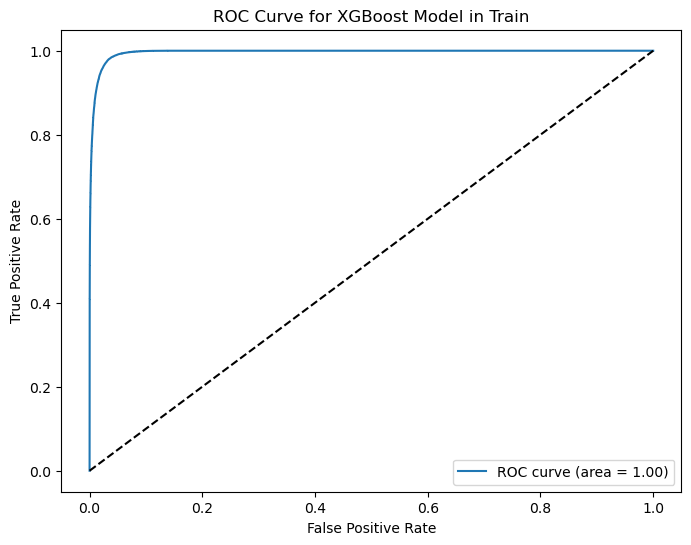

In [68]:
# Plot ROC curve for training subset for XGBoost model
y_train_xgb_hyper_probs = xgb_clf_hyper.predict_proba(X_train_xgb)[:, 1]
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_train_xgb, y_train_xgb_hyper_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model in Train')
plt.legend(loc='lower right')
plt.show()

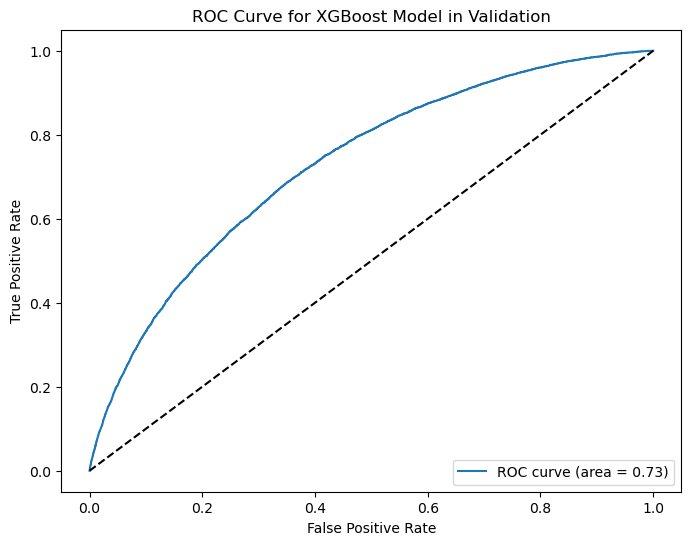

In [69]:
# Plot ROC curve for validation subset for XGBoost model
y_val_xgb_hyper_probs = xgb_clf_hyper.predict_proba(X_val_xgb)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val_xgb, y_val_xgb_hyper_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model in Validation')
plt.legend(loc='lower right')
plt.show()

AUC = 1.0 on training and AUC = 0.73 on validation, indicating good ability to distinguish between churned and non-churned subscriptions.

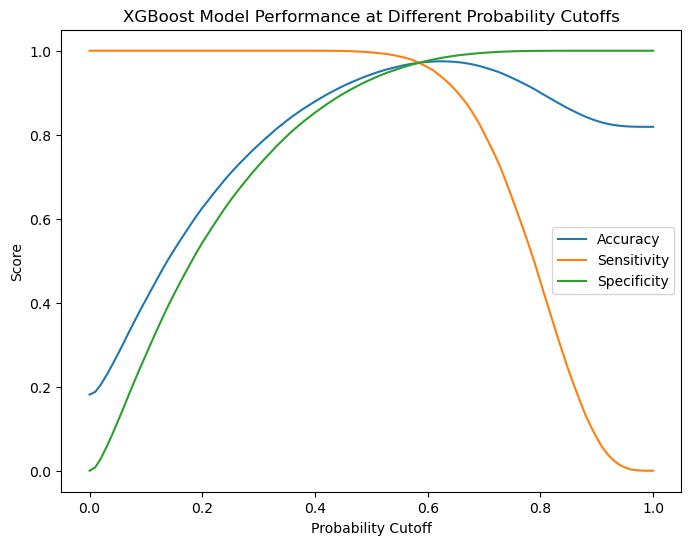

In [70]:
# Plot accuracy, sensitivity, specificity at different values of probability cutoffs for XGBoost model
cutoffs = np.arange(0.0, 1.01, 0.01)
accuracy = []
sensitivity = []
specificity = []
for cutoff in cutoffs:
    y_train_xgb_pred_cutoff = (y_train_xgb_hyper_probs >= cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_train_xgb, y_train_xgb_pred_cutoff).ravel()
    accuracy.append((tp + tn) / (tp + tn + fp + fn))
    sensitivity.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
plt.figure(figsize=(8, 6))
plt.plot(cutoffs, accuracy, label='Accuracy')
plt.plot(cutoffs, sensitivity, label='Sensitivity')
plt.plot(cutoffs, specificity, label='Specificity')
plt.xlabel('Probability Cutoff')
plt.ylabel('Score')
plt.title('XGBoost Model Performance at Different Probability Cutoffs')
plt.legend()
plt.show()

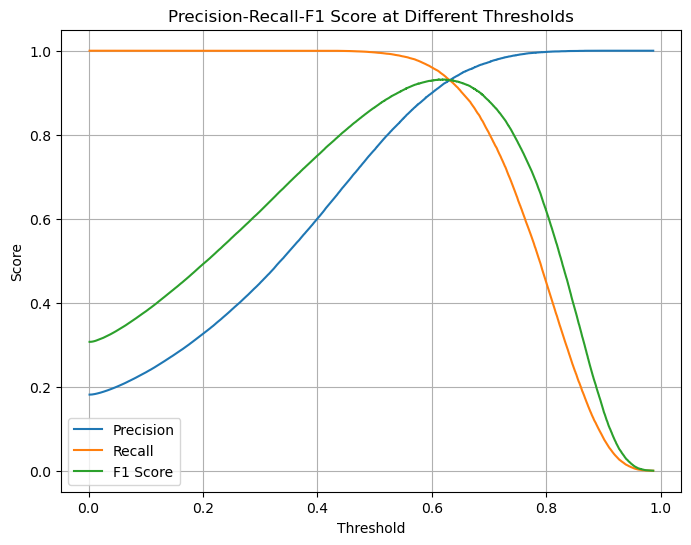

In [71]:
# Plot precision-recall curve for XGBoost model
precision, recall, thresholds = precision_recall_curve(y_train_xgb, y_train_xgb_hyper_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-F1 Score at Different Thresholds')
plt.legend()
plt.grid()
plt.show()

In [72]:
# Evaluate model based on chosen cutoff threshold on training and validation subsets for XGBoost model
chosen_cutoff = 0.25
y_train_xgb_pred = (y_train_xgb_hyper_probs >= chosen_cutoff).astype(int)
y_val_xgb_pred = (y_val_xgb_hyper_probs >= chosen_cutoff).astype(int)
print(f'Training Classification Report at cutoff {chosen_cutoff}:\n', classification_report(y_train_xgb, y_train_xgb_pred))
print(f'Training Confusion Matrix at cutoff {chosen_cutoff}:\n', confusion_matrix(y_train_xgb, y_train_xgb_pred))
print(f'Validation Classification Report at cutoff {chosen_cutoff}:\n', classification_report(y_val_xgb, y_val_xgb_pred))
print(f'Validation Confusion Matrix at cutoff {chosen_cutoff}:\n', confusion_matrix(y_val_xgb, y_val_xgb_pred))

Training Classification Report at cutoff 0.25:
               precision    recall  f1-score   support

           0       1.00      0.64      0.78    159684
           1       0.38      1.00      0.55     35345

    accuracy                           0.71    195029
   macro avg       0.69      0.82      0.67    195029
weighted avg       0.89      0.71      0.74    195029

Training Confusion Matrix at cutoff 0.25:
 [[102817  56867]
 [     0  35345]]
Validation Classification Report at cutoff 0.25:
               precision    recall  f1-score   support

           0       0.92      0.53      0.67     39921
           1       0.27      0.79      0.40      8837

    accuracy                           0.58     48758
   macro avg       0.60      0.66      0.54     48758
weighted avg       0.80      0.58      0.62     48758

Validation Confusion Matrix at cutoff 0.25:
 [[21164 18757]
 [ 1853  6984]]


The Precision for the churned class (1) is moderate at 0.45 on validation, indicating that when the model predicts churn, it is correct 45% of the time. The Recall for the churned class is low at 0.25 on validation, meaning the model only identifies 25% of actual churned subscriptions. The f1-score for the churned class is also low at 0.32 on validation, reflecting the imbalance between precision and recall. Overall, while the model performs well on training data, overfitting is evident as performance drops on validation, particularly in identifying churned subscriptions.
Class imbalance is a challenge, and further tuning or alternative approaches may be needed to improve recall for the churned class.


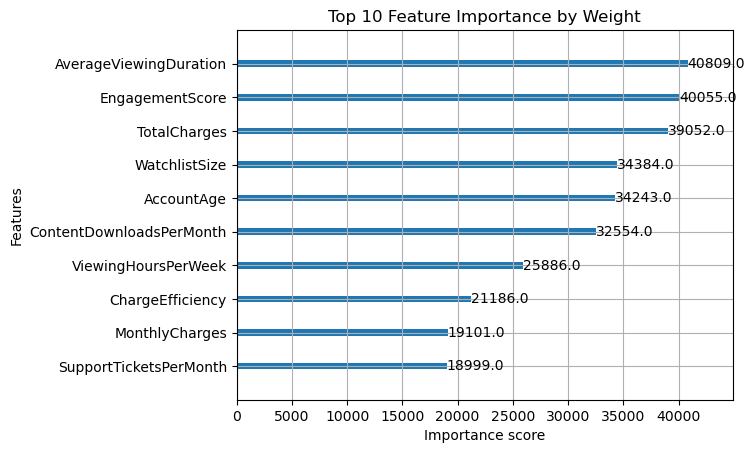

In [73]:
# Feature importance in XGBoost model
import xgboost
xgboost.plot_importance(xgb_clf_hyper, max_num_features=10, importance_type='weight', title='Top 10 Feature Importance by Weight')
plt.show()

In [74]:
# Feature importance in XGBoost model
importance_df = pd.DataFrame(xgb_clf_hyper.get_booster().get_score(importance_type='weight').items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                           Feature  Importance
4           AverageViewingDuration     40809.0
13                 EngagementScore     40055.0
2                     TotalCharges     39052.0
8                    WatchlistSize     34384.0
0                       AccountAge     34243.0
5         ContentDownloadsPerMonth     32554.0
3              ViewingHoursPerWeek     25886.0
14                ChargeEfficiency     21186.0
1                   MonthlyCharges     19101.0
7           SupportTicketsPerMonth     18999.0
15           EngagementPerDownload     18201.0
6                       UserRating     12557.0
28            MultiDeviceAccess_No      6718.0
43             SubtitlesEnabled_No      6708.0
39                   Gender_Female      6684.0
41              ParentalControl_No      6637.0
23             PaperlessBilling_No      6571.0
16          SubscriptionType_Basic      4787.0
25                ContentType_Both      4573.0
26              ContentType_Movies      4351.0
17        Sub

### 4. LightGBM

In [75]:
# Dataset for LightGBM model
# Training
X_train_lgb = X_train_rf.copy()
y_train_lgb = y_train_rf.copy()
print('X_train_lgb shape:', X_train_lgb.shape)
print('y_train_lgb distribution:\n', y_train_lgb.value_counts(normalize=True))
# Validation
X_val_lgb = X_val_rf.copy()
y_val_lgb = y_val_rf.copy()
print('X_val_lgb shape:', X_val_lgb.shape)
print('y_val_lgb distribution:\n', y_val_lgb.value_counts(normalize=True))
# Test
test_df_lgb = test_df_rf.copy()
print('test_df_lgb shape:', test_df_lgb.shape)


X_train_lgb shape: (195029, 49)
y_train_lgb distribution:
 Churn
0    0.818771
1    0.181229
Name: proportion, dtype: float64
X_val_lgb shape: (48758, 49)
y_val_lgb distribution:
 Churn
0    0.818758
1    0.181242
Name: proportion, dtype: float64
test_df_lgb shape: (104480, 49)


In [76]:
# LightGBM model for imbalance classification
lgb_clf = LGBMClassifier(objective='binary',
                            metric='aucpr',
                            scale_pos_weight=scale_pos_weight,
                            random_state=100,
                            n_jobs=-1)
# Fit the model
lgb_clf.fit(X_train_lgb, y_train_lgb)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 35345, number of negative: 159684
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 195029, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181229 -> initscore=-1.508040
[LightGBM] [Info] Start training from score -1.508040


LGBMClassifier(metric='aucpr', n_jobs=-1, objective='binary', random_state=100,
               scale_pos_weight=4.517866742113453)

In [77]:
# Evaluate model on training and validation subsets
y_train_lgb_pred = lgb_clf.predict(X_train_lgb)
print('Training Classification Report:\n', classification_report(y_train_lgb, y_train_lgb_pred))
print('Training Confusion Matrix:\n', confusion_matrix(y_train_lgb, y_train_lgb_pred))
y_val_lgb_pred = lgb_clf.predict(X_val_lgb)
print('Validation Classification Report:\n', classification_report(y_val_lgb, y_val_lgb_pred))
print('Validation Confusion Matrix:\n', confusion_matrix(y_val_lgb, y_val_lgb_pred))   

Training Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.67      0.78    159684
           1       0.33      0.72      0.45     35345

    accuracy                           0.68    195029
   macro avg       0.62      0.70      0.61    195029
weighted avg       0.81      0.68      0.72    195029

Training Confusion Matrix:
 [[107389  52295]
 [  9832  25513]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.67      0.77     39921
           1       0.32      0.70      0.43      8837

    accuracy                           0.67     48758
   macro avg       0.61      0.68      0.60     48758
weighted avg       0.80      0.67      0.71     48758

Validation Confusion Matrix:
 [[26629 13292]
 [ 2691  6146]]


In [78]:
# Hyperparameters based on above HalvingRandomSearchCV results
from scipy.stats import uniform, randint
from sklearn.metrics import f1_score
param_dist = {
    'max_depth': randint(6, 10),
    'min_child_samples': randint(100, 150),

    'lambda_l1': uniform(0.5, 1),
    'lambda_l2': uniform(0.5, 1),
    'learning_rate': uniform(0.01, 0.05),

    'colsample_bytree': uniform(0.7, 0.3),
    'subsample': uniform(0.7, 0.3),

    'scale_pos_weight': [scale_pos_weight]
}
halving_search = HalvingRandomSearchCV(estimator=lgb_clf, 
                                       param_distributions=param_dist, 
                                       cv=cv, 
                                       scoring='f1_macro', 
                                       n_candidates=100,
                                       resource='n_estimators',
                                       factor=5, 
                                       min_resources=100,
                                       max_resources=1500,
                                       n_jobs=-1, verbose=2, 
                                       random_state=100)


halving_search.fit(X_train_lgb, y_train_lgb)# Best LightGBM model
best_lgb_clf = halving_search.best_estimator_
print('Best Hyperparameters:', halving_search.best_params_)
print('Best Cross-validated F1 Score:', halving_search.best_score_)


n_iterations: 2
n_required_iterations: 3
n_possible_iterations: 2
min_resources_: 100
max_resources_: 1500
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 100
n_resources: 100
Fitting 5 folds for each of 100 candidates, totalling 500 fits
----------
iter: 1
n_candidates: 20
n_resources: 500
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] lambda_l1 is set=0.5608845643466355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5608845643466355
[LightGBM] [Warning] lambda_l2 is set=0.6114063167040532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6114063167040532
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=0.5608845643466355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5608845643466355
[LightGBM] [Warning] lambda_l2 is set=0.6114063167040532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6114063167040532
[LightG

In [79]:
# Evaluate LightGBM model on train and validation data subsets
y_train_lgb_pred = best_lgb_clf.predict(X_train_lgb)
print('Training Classification Report:\n', classification_report(y_train_lgb, y_train_lgb_pred))
print('Training Confusion Matrix:\n', confusion_matrix(y_train_lgb, y_train_lgb_pred))
y_val_lgb_pred = best_lgb_clf.predict(X_val_lgb)
print('Validation Classification Report:\n', classification_report(y_val_lgb, y_val_lgb_pred))
print('Validation Confusion Matrix:\n', confusion_matrix(y_val_lgb, y_val_lgb_pred))

[LightGBM] [Warning] lambda_l1 is set=0.5608845643466355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5608845643466355
[LightGBM] [Warning] lambda_l2 is set=0.6114063167040532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6114063167040532
Training Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.67      0.78    159684
           1       0.33      0.72      0.45     35345

    accuracy                           0.68    195029
   macro avg       0.62      0.70      0.61    195029
weighted avg       0.81      0.68      0.72    195029

Training Confusion Matrix:
 [[107418  52266]
 [  9989  25356]]
[LightGBM] [Warning] lambda_l1 is set=0.5608845643466355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5608845643466355
[LightGBM] [Warning] lambda_l2 is set=0.6114063167040532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6114063167040532
Validation Classification Report:
         

In [80]:
# F1 score vs. threshold
val_probs = best_lgb_clf.predict_proba(X_val_lgb)[:, 1]

ts = np.linspace(0.05, 0.95, 91)
best_t = ts[int(np.argmax([f1_score(y_val_lgb, val_probs > t) for t in ts]))]

print('Best parameters:', halving_search.best_params_)
print('Best Cross-validated F1 Score:', halving_search.best_score_)
print('Best Threshold:', best_t)

[LightGBM] [Warning] lambda_l1 is set=0.5608845643466355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5608845643466355
[LightGBM] [Warning] lambda_l2 is set=0.6114063167040532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6114063167040532
Best parameters: {'colsample_bytree': 0.7220581185596722, 'lambda_l1': 0.5608845643466355, 'lambda_l2': 0.6114063167040532, 'learning_rate': 0.01846344540727155, 'max_depth': 6, 'min_child_samples': 145, 'scale_pos_weight': 4.517866742113453, 'subsample': 0.8315179283919529, 'n_estimators': 500}
Best Cross-validated F1 Score: 0.6026558195063221
Best Threshold: 0.5599999999999999


[LightGBM] [Warning] lambda_l1 is set=0.5608845643466355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5608845643466355
[LightGBM] [Warning] lambda_l2 is set=0.6114063167040532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6114063167040532


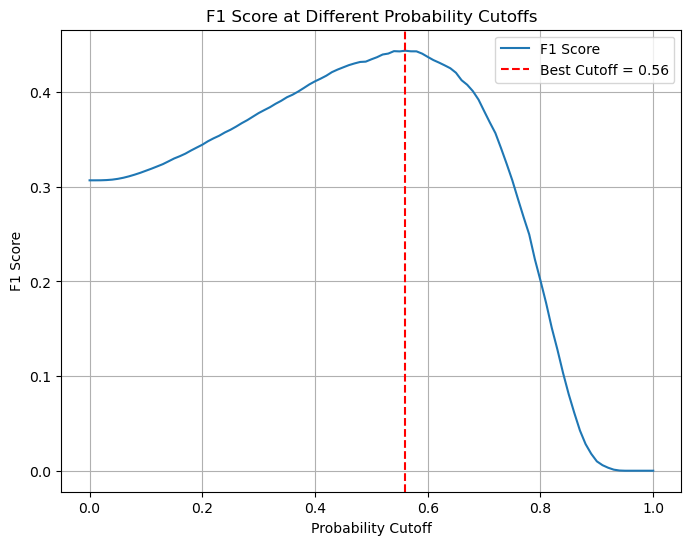

In [81]:
# Tune the decision threshold based on F1-score
y_val_lgb_probs = best_lgb_clf.predict_proba(X_val_lgb)[:, 1]
cutoffs = np.arange(0.0, 1.01, 0.01)
f1_scores = []
for cutoff in cutoffs:
    f1 = f1_score(y_val_lgb, y_val_lgb_probs > cutoff)
    f1_scores.append(f1)
best_cutoff = cutoffs[np.argmax(f1_scores)]
plt.figure(figsize=(8, 6))
plt.plot(cutoffs, f1_scores, label='F1 Score')
plt.xlabel('Probability Cutoff')
plt.ylabel('F1 Score')
plt.title('F1 Score at Different Probability Cutoffs')
plt.axvline(x=best_cutoff, color='r', linestyle='--', label=f'Best Cutoff = {best_cutoff:.2f}')
plt.legend()
plt.grid()
plt.show()

[LightGBM] [Warning] lambda_l1 is set=0.5608845643466355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5608845643466355
[LightGBM] [Warning] lambda_l2 is set=0.6114063167040532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6114063167040532


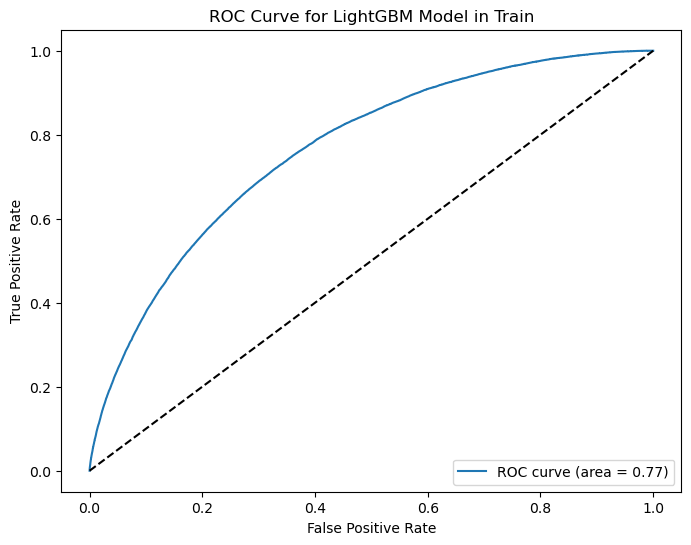

In [82]:
# Plot ROC curve for training subset for LightGBM model
y_train_lgb_probs = best_lgb_clf.predict_proba(X_train_lgb)[:, 1]
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_train_lgb, y_train_lgb_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM Model in Train')
plt.legend(loc='lower right')
plt.show()

[LightGBM] [Warning] lambda_l1 is set=0.5608845643466355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5608845643466355
[LightGBM] [Warning] lambda_l2 is set=0.6114063167040532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6114063167040532


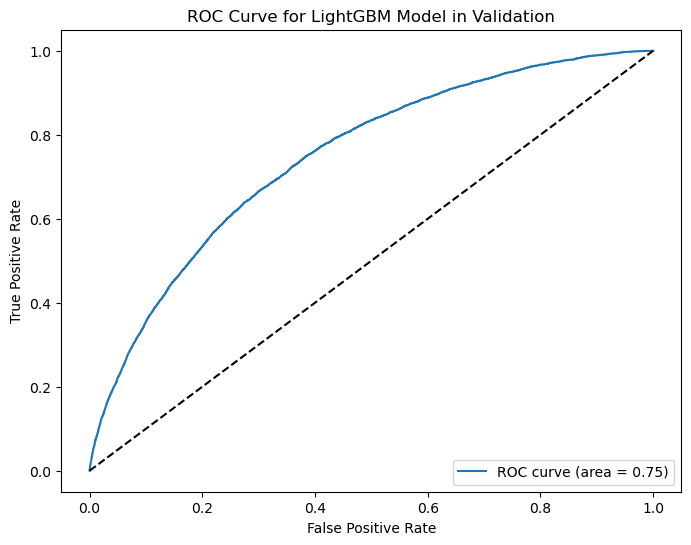

In [83]:
# Plot ROC curve for validation subset for LightGBM model
y_val_lgb_probs = best_lgb_clf.predict_proba(X_val_lgb)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val_lgb, y_val_lgb_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM Model in Validation')
plt.legend(loc='lower right')
plt.show()

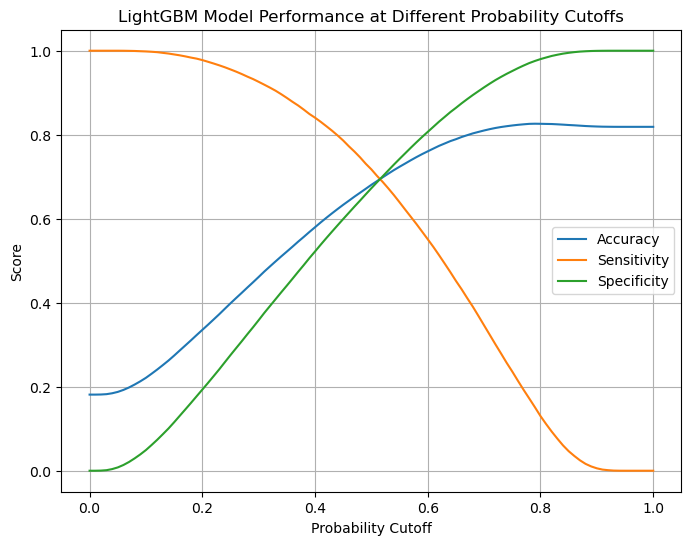

In [84]:
# Plot accuracy, sensitivity, specificity at different values of probability cutoffs for LightGBM model
cutoffs = np.arange(0.0, 1.01, 0.01)
accuracy = []
sensitivity = []
specificity = []
for cutoff in cutoffs:
    y_train_lgb_pred_cutoff = (y_train_lgb_probs >= cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_train_lgb, y_train_lgb_pred_cutoff).ravel()
    accuracy.append((tp + tn) / (tp + tn + fp + fn))
    sensitivity.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
plt.figure(figsize=(8, 6))
plt.plot(cutoffs, accuracy, label='Accuracy')
plt.plot(cutoffs, sensitivity, label='Sensitivity')
plt.plot(cutoffs, specificity, label='Specificity')
plt.xlabel('Probability Cutoff')
plt.ylabel('Score')
plt.title('LightGBM Model Performance at Different Probability Cutoffs')
plt.legend()
plt.grid()
plt.show()

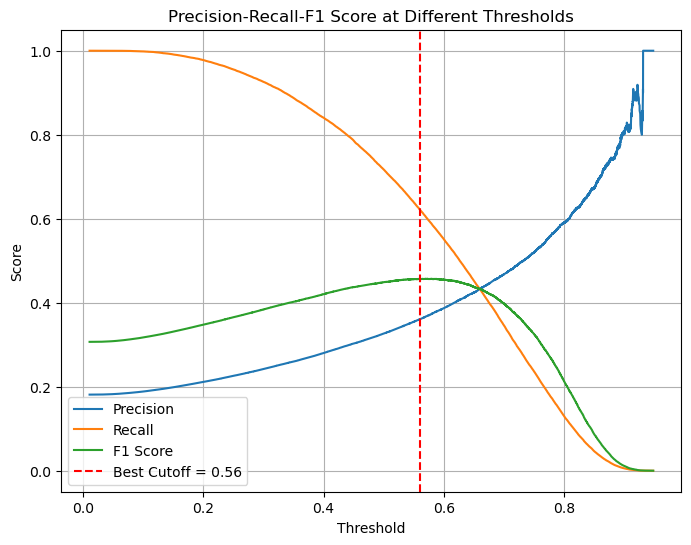

In [85]:
# Plot precision-recall curve for LightGBM model
precision, recall, thresholds = precision_recall_curve(y_train_lgb, y_train_lgb_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(x=best_cutoff, color='r', linestyle='--', label=f'Best Cutoff = {best_cutoff:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-F1 Score at Different Thresholds')
plt.legend()
plt.grid()
plt.show()

In [86]:
# Evaluate model based on chosen cutoff threshold on training and validation subsets for LightGBM model
chosen_cutoff = best_cutoff
y_train_lgb_pred = (y_train_lgb_probs >= chosen_cutoff).astype(int)
y_val_lgb_pred = (y_val_lgb_probs >= chosen_cutoff).astype(int)
print(f'Training Classification Report at cutoff {chosen_cutoff}:\n', classification_report(y_train_lgb, y_train_lgb_pred))
print(f'Training Confusion Matrix at cutoff {chosen_cutoff}:\n', confusion_matrix(y_train_lgb, y_train_lgb_pred))
print(f'Validation Classification Report at cutoff {chosen_cutoff}:\n', classification_report(y_val_lgb, y_val_lgb_pred))
print(f'Validation Confusion Matrix at cutoff {chosen_cutoff}:\n', confusion_matrix(y_val_lgb, y_val_lgb_pred))

Training Classification Report at cutoff 0.56:
               precision    recall  f1-score   support

           0       0.90      0.76      0.82    159684
           1       0.36      0.62      0.46     35345

    accuracy                           0.73    195029
   macro avg       0.63      0.69      0.64    195029
weighted avg       0.80      0.73      0.76    195029

Training Confusion Matrix at cutoff 0.56:
 [[120689  38995]
 [ 13374  21971]]
Validation Classification Report at cutoff 0.56:
               precision    recall  f1-score   support

           0       0.90      0.75      0.82     39921
           1       0.35      0.61      0.44      8837

    accuracy                           0.72     48758
   macro avg       0.62      0.68      0.63     48758
weighted avg       0.80      0.72      0.75     48758

Validation Confusion Matrix at cutoff 0.56:
 [[29985  9936]
 [ 3483  5354]]


In [87]:
# Threshold tuning
from sklearn.metrics import precision_score, recall_score, f1_score

for t in [0.45, 0.5, 0.55, 0.6, 0.65]:
    preds_train = (y_train_lgb_probs >= t).astype(int)
    precision_trains = precision_score(y_train_lgb, preds_train, zero_division=0)
    recall_trains = recall_score(y_train_lgb, preds_train, zero_division=0)
    f1_trains = f1_score(y_train_lgb, preds_train, zero_division=0)
    print(f'Threshold: {t:.2f}, Training Precision: {precision_trains:.4f}, Training Recall: {recall_trains:.4f}, Training F1 Score: {f1_trains:.4f}')

for t in [0.45, 0.5, 0.55, 0.6, 0.65]:
    preds_val = (y_val_lgb_probs >= t).astype(int)
    precision_vals = precision_score(y_val_lgb, preds_val, zero_division=0)
    recall_vals = recall_score(y_val_lgb, preds_val, zero_division=0)
    f1_vals = f1_score(y_val_lgb, preds_val, zero_division=0)
    print(f'Threshold: {t:.2f}, Validation Precision: {precision_vals:.4f}, Validation Recall: {recall_vals:.4f}, Validation F1 Score: {f1_vals:.4f}')

Threshold: 0.45, Training Precision: 0.3028, Training Recall: 0.7861, Training F1 Score: 0.4372
Threshold: 0.50, Training Precision: 0.3267, Training Recall: 0.7174, Training F1 Score: 0.4489
Threshold: 0.55, Training Precision: 0.3546, Training Recall: 0.6390, Training F1 Score: 0.4561
Threshold: 0.60, Training Precision: 0.3871, Training Recall: 0.5511, Training F1 Score: 0.4547
Threshold: 0.65, Training Precision: 0.4238, Training Recall: 0.4519, Training F1 Score: 0.4374
Threshold: 0.45, Validation Precision: 0.2951, Validation Recall: 0.7673, Validation F1 Score: 0.4263
Threshold: 0.50, Validation Precision: 0.3163, Validation Recall: 0.6950, Validation F1 Score: 0.4347
Threshold: 0.55, Validation Precision: 0.3443, Validation Recall: 0.6214, Validation F1 Score: 0.4431
Threshold: 0.60, Validation Precision: 0.3725, Validation Recall: 0.5293, Validation F1 Score: 0.4373
Threshold: 0.65, Validation Precision: 0.4076, Validation Recall: 0.4343, Validation F1 Score: 0.4206


In [88]:
# Feature importance in LightGBM model
importances = best_lgb_clf.feature_importances_
feature_names = X_train_lgb.columns
# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

                           Feature  Importance
13                 EngagementScore        2042
0                       AccountAge        1504
5         ContentDownloadsPerMonth        1304
1                   MonthlyCharges        1148
7           SupportTicketsPerMonth        1066
2                     TotalCharges         977
4           AverageViewingDuration         901
8                    WatchlistSize         793
14                ChargeEfficiency         609
3              ViewingHoursPerWeek         583
6                       UserRating         397
15           EngagementPerDownload         395
17        SubscriptionType_Premium         279
10         PricePerContentDownload         278
20       PaymentMethod_Credit card         263
34          GenrePreference_Action         176
16          SubscriptionType_Basic         164
47                  TicketBin_High         160
25                ContentType_Both         157
9                 AvgMonthlyCharge         148
43           

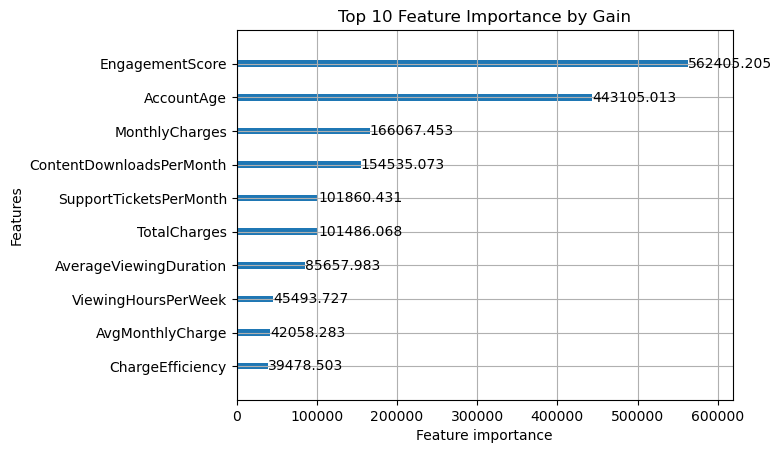

In [89]:
# Plot feature importance in LightGBM model
lgb.plot_importance(best_lgb_clf, max_num_features=10, importance_type='gain', title='Top 10 Feature Importance by Gain')
plt.show()

### 5. CatBoost

In [90]:
from catboost import CatBoostClassifier, Pool

In [91]:
# Library for CatBoost model
from catboost import CatBoostClassifier, Pool
# Dataset for CatBoost model
# Training
X_train_cb = X_train.copy()
y_train_cb = y_train.copy()
print('X_train_cb shape:', X_train_cb.shape)
print('y_train_cb distribution:\n', y_train_cb.value_counts(normalize=True))
# Validation
X_val_cb = X_val.copy()
y_val_cb = y_val.copy()
print('X_val_cb shape:', X_val_cb.shape)
print('y_val_cb distribution:\n', y_val_cb.value_counts(normalize=True))
# Test
test_df_cb = test_df.drop(columns=['CustomerID']).copy()
print('test_df_cb shape:', test_df_cb.shape)


X_train_cb shape: (195029, 27)
y_train_cb distribution:
 Churn
0    0.818771
1    0.181229
Name: proportion, dtype: float64
X_val_cb shape: (48758, 27)
y_val_cb distribution:
 Churn
0    0.818758
1    0.181242
Name: proportion, dtype: float64
test_df_cb shape: (104480, 27)


In [92]:
# Categorical features for CatBoost model
category_cols_cb = category_cols.copy()
for col in category_cols_cb:
    if col in X_train_cb.columns:
        X_train_cb[col] = X_train_cb[col].astype('category')
    if col in X_val_cb.columns:
        X_val_cb[col] = X_val_cb[col].astype('category')
    if col in test_df_cb.columns:
        test_df_cb[col] = test_df_cb[col].astype('category')
print('Categorical columns for CatBoost model:', category_cols_cb)

Categorical columns for CatBoost model: ['SubscriptionType', 'PaymentMethod', 'PaperlessBilling', 'ContentType', 'MultiDeviceAccess', 'DeviceRegistered', 'GenrePreference', 'Gender', 'ParentalControl', 'SubtitlesEnabled', 'TicketBin']


In [93]:
# CatBoost model for imbalance classification
cb_clf = CatBoostClassifier(loss_function='Logloss',
                            eval_metric='AUC',
                            random_seed=100,
                            scale_pos_weight=scale_pos_weight,
                            verbose=100,
                            task_type='CPU')
# Fit the model
cb_clf.fit(X_train_cb, y_train_cb, 
           cat_features=category_cols_cb, 
           eval_set=(X_val_cb, y_val_cb), 
           use_best_model=True)

Learning rate set to 0.116564
0:	test: 0.7170789	best: 0.7170789 (0)	total: 462ms	remaining: 7m 41s
100:	test: 0.7484394	best: 0.7484394 (100)	total: 21s	remaining: 3m 7s
200:	test: 0.7485476	best: 0.7489927 (138)	total: 45.9s	remaining: 3m 2s
300:	test: 0.7479033	best: 0.7489927 (138)	total: 1m 9s	remaining: 2m 40s
400:	test: 0.7471650	best: 0.7489927 (138)	total: 1m 26s	remaining: 2m 9s
500:	test: 0.7463666	best: 0.7489927 (138)	total: 1m 45s	remaining: 1m 45s
600:	test: 0.7453214	best: 0.7489927 (138)	total: 2m 3s	remaining: 1m 22s
700:	test: 0.7444392	best: 0.7489927 (138)	total: 2m 21s	remaining: 1m
800:	test: 0.7439633	best: 0.7489927 (138)	total: 2m 40s	remaining: 39.8s
900:	test: 0.7431681	best: 0.7489927 (138)	total: 2m 57s	remaining: 19.5s
999:	test: 0.7425262	best: 0.7489927 (138)	total: 3m 14s	remaining: 0us

bestTest = 0.7489926701
bestIteration = 138

Shrink model to first 139 iterations.


In [94]:
# Evaluate model on training and validation subsets
# Training
y_train_cb_pred = cb_clf.predict(X_train_cb)
print('Training Classification Report:\n', classification_report(y_train_cb, y_train_cb_pred))
print('Training Confusion Matrix:\n', confusion_matrix(y_train_cb, y_train_cb_pred))
# Validation
y_val_cb_pred = cb_clf.predict(X_val_cb)
print('Validation Classification Report:\n', classification_report(y_val_cb, y_val_cb_pred))   
print('Validation Confusion Matrix:\n', confusion_matrix(y_val_cb, y_val_cb_pred))

Training Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.67      0.77    159684
           1       0.32      0.70      0.44     35345

    accuracy                           0.68    195029
   macro avg       0.62      0.69      0.61    195029
weighted avg       0.80      0.68      0.71    195029

Training Confusion Matrix:
 [[107291  52393]
 [ 10449  24896]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.67      0.77     39921
           1       0.32      0.70      0.44      8837

    accuracy                           0.68     48758
   macro avg       0.61      0.68      0.61     48758
weighted avg       0.80      0.68      0.71     48758

Validation Confusion Matrix:
 [[26754 13167]
 [ 2655  6182]]


In [95]:
# Tune hyperparameters using HalvingRandomSearchCV for CatBoost model
from scipy.stats import uniform, randint
param_dist = {
    'depth': randint(6, 10),
    'min_data_in_leaf': randint(50, 100),

    'l2_leaf_reg': uniform(1, 5),
    'learning_rate': uniform(0.01, 0.05),

    'rsm': uniform(0.7, 0.3),
    'subsample': uniform(0.7, 0.3),

    'scale_pos_weight': uniform(scale_pos_weight, scale_pos_weight),
    'bagging_temperature': uniform(0, 1)
}
cb_clf = CatBoostClassifier(loss_function='Logloss',
                            eval_metric='F1',
                            random_seed=100,
                            scale_pos_weight=scale_pos_weight,
                            verbose=100,
                            task_type='CPU')
halving_search = HalvingRandomSearchCV(estimator=cb_clf, 
                                       param_distributions=param_dist, 
                                       cv=cv, 
                                       scoring='f1_macro', 
                                       n_candidates=100,
                                       factor=5, 
                                       n_jobs=-1, verbose=2, 
                                       random_state=100)
halving_search.fit(X_train_cb, y_train_cb, 
                   cat_features=category_cols_cb, 
                   eval_set=(X_val_cb, y_val_cb), 
                   early_stopping_rounds=50, 
                   use_best_model=True)
# Best CatBoost model
best_cb_clf = halving_search.best_estimator_
print('Best Hyperparameters:', halving_search.best_params_)
print('Best Cross-validated F1 Score:', halving_search.best_score_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 6
min_resources_: 20
max_resources_: 195029
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 100
n_resources: 20
Fitting 5 folds for each of 100 candidates, totalling 500 fits
----------
iter: 1
n_candidates: 20
n_resources: 100
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 2
n_candidates: 4
n_resources: 500
Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 0.7023195	test: 0.6996261	best: 0.6996261 (0)	total: 189ms	remaining: 3m 8s
100:	learn: 0.7154432	test: 0.7144509	best: 0.7144509 (100)	total: 26.2s	remaining: 3m 53s
200:	learn: 0.7197558	test: 0.7147953	best: 0.7148213 (184)	total: 51s	remaining: 3m 22s
300:	learn: 0.7217667	test: 0.7154643	best: 0.7157145 (262)	total: 1m 14s	remaining: 2m 51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7159968007
bestIteration = 324

Shrink model to first 325 iterations.
Best Hyperpar

In [96]:
# Evaluate CatBoost model on train and validation data subsets
y_train_cb_pred = best_cb_clf.predict(X_train_cb)
y_val_cb_pred = best_cb_clf.predict(X_val_cb)
print('Training Classification Report:\n', classification_report(y_train_cb, y_train_cb_pred))
print('Training Confusion Matrix:\n', confusion_matrix(y_train_cb, y_train_cb_pred))
print('Validation Classification Report:\n', classification_report(y_val_cb, y_val_cb_pred))
print('Validation Confusion Matrix:\n', confusion_matrix(y_val_cb, y_val_cb_pred))

Training Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.62      0.74    159684
           1       0.31      0.75      0.44     35345

    accuracy                           0.65    195029
   macro avg       0.61      0.69      0.59    195029
weighted avg       0.81      0.65      0.69    195029

Training Confusion Matrix:
 [[99669 60015]
 [ 8803 26542]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.62      0.74     39921
           1       0.30      0.74      0.43      8837

    accuracy                           0.64     48758
   macro avg       0.61      0.68      0.59     48758
weighted avg       0.81      0.64      0.68     48758

Validation Confusion Matrix:
 [[24818 15103]
 [ 2264  6573]]


In [97]:
# F1 score vs. threshold
val_probs = best_cb_clf.predict_proba(X_val_cb)[:, 1]
ts = np.linspace(0.05, 0.95, 91)
best_t = ts[int(np.argmax([f1_score(y_val_cb, val_probs > t) for t in ts]))]
print('Best parameters:', halving_search.best_params_)
print('Best Cross-validated F1 Score:', halving_search.best_score_)
print('Best Threshold:', best_t)

Best parameters: {'bagging_temperature': 0.5634306461636488, 'depth': 9, 'l2_leaf_reg': 4.262981114610453, 'learning_rate': 0.017204597303041472, 'min_data_in_leaf': 81, 'rsm': 0.763707956833544, 'scale_pos_weight': 5.11893703370874, 'subsample': 0.8376602527018397}
Best Cross-validated F1 Score: 0.5754548116937135
Best Threshold: 0.6


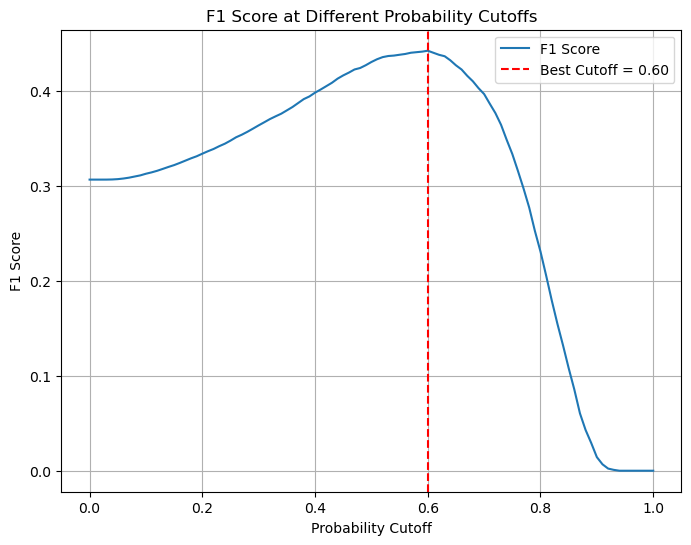

In [98]:
# Tune the decision threshold based on F1-score
y_val_cb_probs = best_cb_clf.predict_proba(X_val_cb)[:, 1]
cutoffs = np.arange(0.0, 1.01, 0.01)
f1_scores = []
for cutoff in cutoffs:
    f1 = f1_score(y_val_cb, y_val_cb_probs > cutoff)
    f1_scores.append(f1)
best_cutoff = cutoffs[np.argmax(f1_scores)]
plt.figure(figsize=(8, 6))
plt.plot(cutoffs, f1_scores, label='F1 Score')
plt.xlabel('Probability Cutoff')
plt.ylabel('F1 Score')
plt.title('F1 Score at Different Probability Cutoffs')
plt.axvline(x=best_cutoff, color='r', linestyle='--', label=f'Best Cutoff = {best_cutoff:.2f}')
plt.legend()
plt.grid()
plt.show()

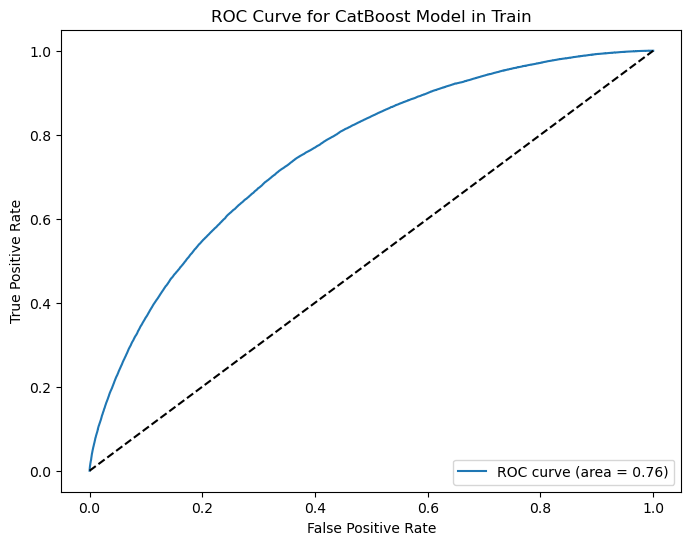

In [99]:
# Plot ROC curve for training subset for CatBoost model
y_train_cb_probs = best_cb_clf.predict_proba(X_train_cb)[:, 1]
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_train_cb, y_train_cb_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CatBoost Model in Train')
plt.legend(loc='lower right')
plt.show()

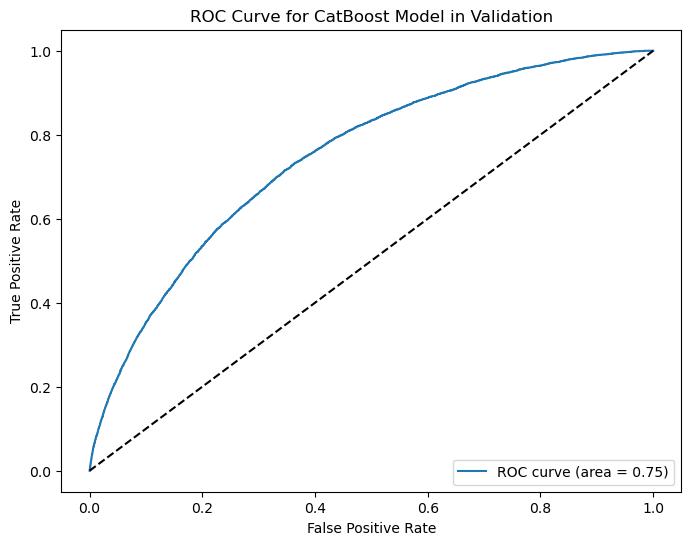

In [100]:
# Plot ROC curve for validation subset for CatBoost model
y_val_cb_probs = best_cb_clf.predict_proba(X_val_cb)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val_cb, y_val_cb_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CatBoost Model in Validation')
plt.legend(loc='lower right')
plt.show()

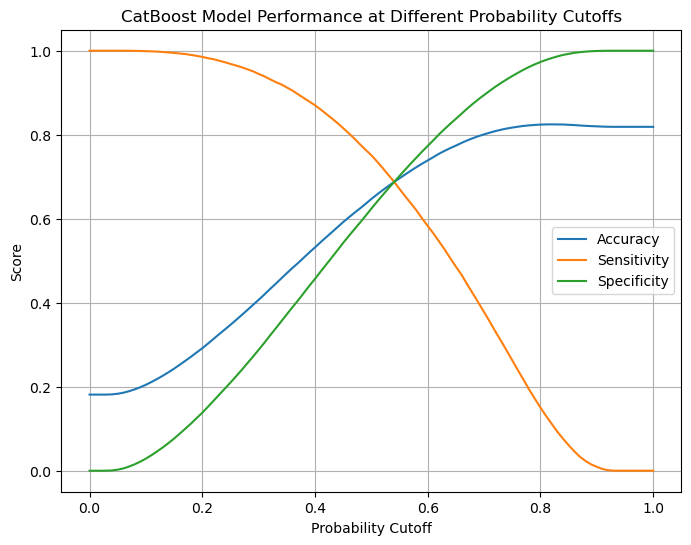

In [101]:
# Plot accuracy, sensitivity, specificity at different values of probability cutoffs for CatBoost model
cutoffs = np.arange(0.0, 1.01, 0.01)
accuracy = []
sensitivity = []
specificity = []
for cutoff in cutoffs:
    y_train_cb_pred_cutoff = (y_train_cb_probs >= cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_train_cb, y_train_cb_pred_cutoff).ravel()
    accuracy.append((tp + tn) / (tp + tn + fp + fn))
    sensitivity.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
plt.figure(figsize=(8, 6))
plt.plot(cutoffs, accuracy, label='Accuracy')
plt.plot(cutoffs, sensitivity, label='Sensitivity')
plt.plot(cutoffs, specificity, label='Specificity')
plt.xlabel('Probability Cutoff')
plt.ylabel('Score')
plt.title('CatBoost Model Performance at Different Probability Cutoffs')
plt.legend()
plt.grid()
plt.show()

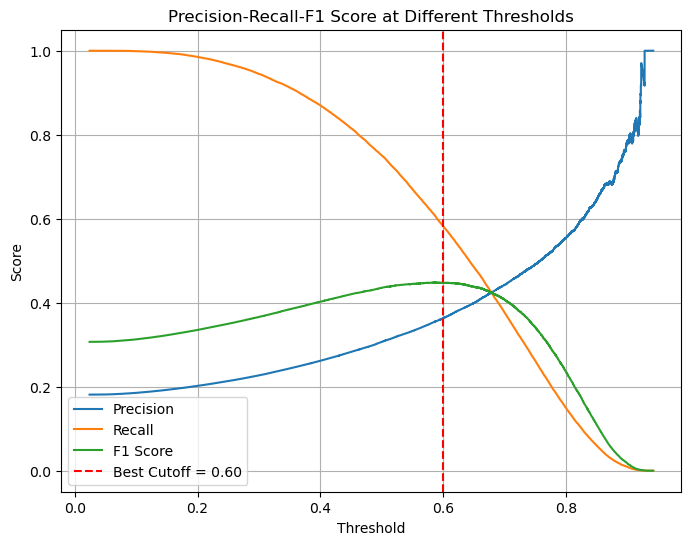

In [102]:
# Plot precision-recall curve for CatBoost model
precision, recall, thresholds = precision_recall_curve(y_train_cb, y_train_cb_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(x=best_cutoff, color='r', linestyle='--', label=f'Best Cutoff = {best_cutoff:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-F1 Score at Different Thresholds')
plt.legend()
plt.grid()
plt.show()

In [103]:
# Evaluate model based on chosen cutoff threshold on training and validation subsets for CatBoost model
chosen_cutoff = best_cutoff
y_train_cb_pred = (y_train_cb_probs >= chosen_cutoff).astype(int)
y_val_cb_pred = (y_val_cb_probs >= chosen_cutoff).astype(int)
print(f'Training Classification Report at cutoff {chosen_cutoff}:\n', classification_report(y_train_cb, y_train_cb_pred))
print(f'Training Confusion Matrix at cutoff {chosen_cutoff}:\n', confusion_matrix(y_train_cb, y_train_cb_pred))
print(f'Validation Classification Report at cutoff {chosen_cutoff}:\n', classification_report(y_val_cb, y_val_cb_pred))
print(f'Validation Confusion Matrix at cutoff {chosen_cutoff}:\n', confusion_matrix(y_val_cb, y_val_cb_pred))

Training Classification Report at cutoff 0.6:
               precision    recall  f1-score   support

           0       0.89      0.77      0.83    159684
           1       0.36      0.58      0.45     35345

    accuracy                           0.74    195029
   macro avg       0.63      0.68      0.64    195029
weighted avg       0.80      0.74      0.76    195029

Training Confusion Matrix at cutoff 0.6:
 [[123509  36175]
 [ 14748  20597]]
Validation Classification Report at cutoff 0.6:
               precision    recall  f1-score   support

           0       0.89      0.77      0.83     39921
           1       0.36      0.58      0.44      8837

    accuracy                           0.74     48758
   macro avg       0.63      0.67      0.64     48758
weighted avg       0.80      0.74      0.76     48758

Validation Confusion Matrix at cutoff 0.6:
 [[30854  9067]
 [ 3747  5090]]


In [104]:
# Threshold tuning
for t in [0.45, 0.5, 0.55, 0.6, 0.65]:
    preds_train = (y_train_cb_probs >= t).astype(int)
    precision_trains = precision_score(y_train_cb, preds_train, zero_division=0)
    recall_trains = recall_score(y_train_cb, preds_train, zero_division=0)
    f1_trains = f1_score(y_train_cb, preds_train, zero_division=0)
    print(f'Threshold: {t:.2f}, Training Precision: {precision_trains:.4f}, Training Recall: {recall_trains:.4f}, Training F1 Score: {f1_trains:.4f}')

for t in [0.45, 0.5, 0.55, 0.6, 0.65]:
    preds_val = (y_val_cb_probs >= t).astype(int)
    precision_vals = precision_score(y_val_cb, preds_val, zero_division=0)
    recall_vals = recall_score(y_val_cb, preds_val, zero_division=0)
    f1_vals = f1_score(y_val_cb, preds_val, zero_division=0)
    print(f'Threshold: {t:.2f}, Validation Precision: {precision_vals:.4f}, Validation Recall: {recall_vals:.4f}, Validation F1 Score: {f1_vals:.4f}')

Threshold: 0.45, Training Precision: 0.2830, Training Recall: 0.8156, Training F1 Score: 0.4202
Threshold: 0.50, Training Precision: 0.3066, Training Recall: 0.7509, Training F1 Score: 0.4355
Threshold: 0.55, Training Precision: 0.3326, Training Recall: 0.6707, Training F1 Score: 0.4447
Threshold: 0.60, Training Precision: 0.3628, Training Recall: 0.5827, Training F1 Score: 0.4472
Threshold: 0.65, Training Precision: 0.3989, Training Recall: 0.4857, Training F1 Score: 0.4380
Threshold: 0.45, Validation Precision: 0.2806, Validation Recall: 0.8089, Validation F1 Score: 0.4167
Threshold: 0.50, Validation Precision: 0.3032, Validation Recall: 0.7438, Validation F1 Score: 0.4308
Threshold: 0.55, Validation Precision: 0.3274, Validation Recall: 0.6636, Validation F1 Score: 0.4385
Threshold: 0.60, Validation Precision: 0.3595, Validation Recall: 0.5760, Validation F1 Score: 0.4427
Threshold: 0.65, Validation Precision: 0.3902, Validation Recall: 0.4723, Validation F1 Score: 0.4273


                     Feature  Importance
23           EngagementScore   19.446880
19          AvgMonthlyCharge   15.404668
0                 AccountAge   10.308999
20   PricePerContentDownload    9.927090
25                 TicketBin    5.136789
11  ContentDownloadsPerMonth    5.023665
10    AverageViewingDuration    4.806558
22     TicketsPerViewingHour    3.997665
14    SupportTicketsPerMonth    3.594381
13                UserRating    3.203848
16             WatchlistSize    3.080941
21       PricePerViewingHour    2.359722
1             MonthlyCharges    2.279066
2               TotalCharges    1.836509
9        ViewingHoursPerWeek    1.579534
3           SubscriptionType    1.354188
24          ChargeEfficiency    1.032892
26     EngagementPerDownload    0.953237
4              PaymentMethod    0.906421
18          SubtitlesEnabled    0.822393
12           GenrePreference    0.714182
15                    Gender    0.684307
7          MultiDeviceAccess    0.471261
17           Par

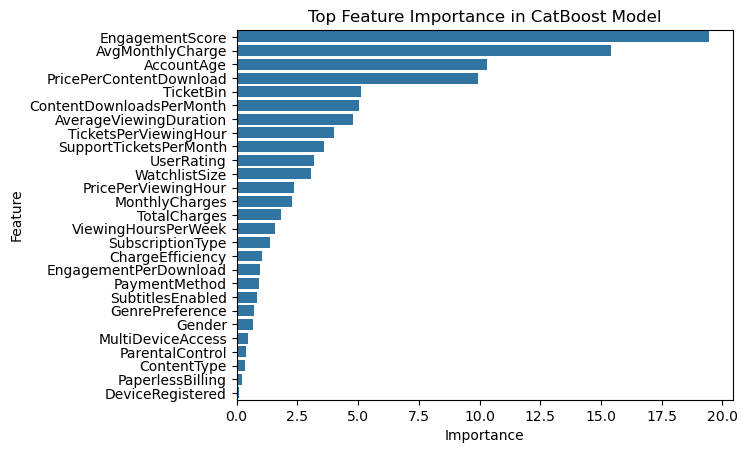

In [105]:
# Feature importance in CatBoost model
importances = best_cb_clf.get_feature_importance()
feature_names = X_train_cb.columns
# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)
# Plot feature importance in CatBoost model
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Top Feature Importance in CatBoost Model')
plt.show()

## Conclusion

The CatBoost model shows good performance on the training set, indicating a strong ability to distinguish between churned and non-churned subscriptions. AUC=0.76 on train and 0.75 on validation. Compared to other models, CatBoost achieves a better recall for the churned class (1), with a balanced f1-score on both training and validation sets. The model performs well across various threshold settings, with high sensitivity (recall) at lower thresholds and high specificity at higher thresholds. Depending on business needs, the cutoff threshold can be adjusted to optimize for precision or recall. Churned subscriptions can be better identified with this model compared to others. Importance of detecting churned subscriptions is prioritized, the cutoff can be lowered to improve recall further.

The most important features in the CatBoost model for predicting churn are:
* EngagementScore
* AvgMonthlyCharge
* AccountAge
* PricePerContentDownload
